In [27]:
import sys
import os
sys.path.append('../..')

# prevents a thread conflict between MKL/OpenMP (used by numpy/scipy) and PyTorch
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAX_THREADS'] = '1'

In [359]:
# libraries
import optuna
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.util import Surv
import pickle

# pytorch
import torch
torch.set_num_threads(1)
import torch.nn as nn
import torchtuples as tt
from torch.optim import AdamW


# Set random seed for reproducibility
np.random.seed(1212)
torch.manual_seed(1212)

# models
from sksurv.linear_model import CoxPHSurvivalAnalysis
from xgbse.converters import convert_to_structured
from xgbse import XGBSEDebiasedBCE
from sksurv.ensemble import RandomSurvivalForest
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from pycox.models import DeepHitSingle, CoxPH
from pycox.evaluation import EvalSurv


# metrics
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored, integrated_brier_score, concordance_index_ipcw


# survshap
from survshap import SurvivalModelExplainer, ModelSurvSHAP

# warnings
# import warnings




In [29]:
# data
X_train = pd.read_parquet('../../data/processed/train_standard_features.parquet')
y_train = pd.read_parquet('../../data/processed/train_targets.parquet')
X_val = pd.read_parquet('../../data/processed/val_standard_features.parquet')
y_val = pd.read_parquet('../../data/processed/val_targets.parquet')
X_test = pd.read_parquet('../../data/processed/test_standard_features.parquet')
y_test = pd.read_parquet('../../data/processed/test_targets.parquet')

y_train_struct = np.array([(bool(e), float(t)) for e, t in zip(y_train['event'], y_train['time'])], 
                        dtype=[('event', bool), ('time', float)])
y_val_struct = np.array([(bool(e), float(t)) for e, t in zip(y_val['event'], y_val['time'])], 
                    dtype=[('event', bool), ('time', float)])
y_test_struct = np.array([(bool(e), float(t)) for e, t in zip(y_test['event'], y_test['time'])], 
                    dtype=[('event', bool), ('time', float)])

y_train_struct_xgbse = convert_to_structured(y_train['time'], y_train['event'])
y_val_struct_xgbse = convert_to_structured(y_val['time'], y_val['event'])
y_test_struct_xgbse = convert_to_structured(y_test['time'], y_test['event'])

In [30]:
min_time = np.min(y_test_struct['time'])
max_time = np.max(y_test_struct['time'])
# Ensure times_for_brier is within [min_time, max_time)
times_for_brier = np.arange(np.ceil(min_time), np.floor(max_time))

In [31]:
min_time, max_time

(1.0, 363.0)

## Cox model

In [32]:
def objective_cox(trial):
    # Hyperparameter search space
    params = {
        'alpha': trial.suggest_float('alpha', 0.001, 10.0, log=True),
        'n_iter': trial.suggest_int('n_iter', 100, 2000),
        'tol': trial.suggest_float('tol', 1e-6, 1e-3, log=True),
    }
    
    times = np.arange(1, 361)
    
    try:
        # Train and evaluate model
        model = CoxPHSurvivalAnalysis(**params)
        model.fit(X_train, y_train_struct)
        
        # Get predictions for both sets
        train_risks = model.predict(X_train)
        val_risks = model.predict(X_val)
        
        # Calculate c-index for both
        train_c_index = concordance_index_censored(
            y_train_struct['event'], y_train_struct['time'], train_risks)[0]
        val_c_index = concordance_index_censored(
            y_val_struct['event'], y_val_struct['time'], val_risks)[0]
        
        # Calculate mean AUC score
        _ , mean_auc = cumulative_dynamic_auc(
            y_train_struct, y_val_struct, val_risks, times)
        
        # Store metrics and coefficients
        trial.set_user_attr('train_c_index', train_c_index)
        trial.set_user_attr('val_c_index', val_c_index)
        trial.set_user_attr('mean_auc', mean_auc)
        
        if hasattr(model, 'coef_'):
            coef_dict = {name: float(coef) for name, coef in zip(X_train.columns, model.coef_)}
            trial.set_user_attr('coefficients', coef_dict)
        
        return val_c_index
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')

# Run optimization
study_cox = optuna.create_study(direction='maximize')
study_cox.optimize(objective_cox, n_trials=20, show_progress_bar=True)

# Save results
best_trial_cox = study_cox.best_trial
print(f"\nBest score: {best_trial_cox.value:.5f}")
print(f"Train c-index: {best_trial_cox.user_attrs['train_c_index']:.5f}")
print(f"Val c-index: {best_trial_cox.user_attrs['val_c_index']:.5f}")
print(f"Mean AUC: {best_trial_cox.user_attrs['mean_auc']:.5f}")
print(f"Best params: {best_trial_cox.params}")

# Save parameters
with open('../../models/best_cox_params.json', 'w') as f:
    json.dump(study_cox.best_params, f, indent=2)

# Save and display coefficients
if 'coefficients' in best_trial_cox.user_attrs:
    coefs = best_trial_cox.user_attrs['coefficients']
    sorted_coefs = dict(sorted(coefs.items(), key=lambda x: abs(x[1]), reverse=True))
    
    with open('../../models/cox_coefficients.json', 'w') as f:
        json.dump(sorted_coefs, f, indent=2)
    
    print(f"\nTop 5 coefficients:")
    for name, value in list(sorted_coefs.items())[:5]:
        print(f"  {name}: {value:.4f}")


[I 2025-06-17 16:56:55,777] A new study created in memory with name: no-name-17564dd0-0cc2-4ae6-ae6d-1a0ecf3443f0


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-17 16:56:58,023] Trial 0 finished with value: 0.6298652111312225 and parameters: {'alpha': 0.02252454131701344, 'n_iter': 818, 'tol': 0.00012685655160088832}. Best is trial 0 with value: 0.6298652111312225.
[I 2025-06-17 16:57:00,101] Trial 1 finished with value: 0.6298501805765423 and parameters: {'alpha': 0.12844713600735772, 'n_iter': 737, 'tol': 4.601445202521553e-05}. Best is trial 0 with value: 0.6298652111312225.
[I 2025-06-17 16:57:02,317] Trial 2 finished with value: 0.6298569510966685 and parameters: {'alpha': 0.03955008320946378, 'n_iter': 1799, 'tol': 1.2390413734442492e-05}. Best is trial 0 with value: 0.6298652111312225.
[I 2025-06-17 16:57:04,611] Trial 3 finished with value: 0.6298456443280577 and parameters: {'alpha': 0.07960717642625559, 'n_iter': 1704, 'tol': 2.5114794037791086e-05}. Best is trial 0 with value: 0.6298652111312225.
[I 2025-06-17 16:57:06,747] Trial 4 finished with value: 0.6298478785996994 and parameters: {'alpha': 0.10574923957601712, 'n_i

In [33]:
# prediction
# Load the best hyperparameters
with open('../../models/best_cox_params.json', 'r') as f:
    best_params = json.load(f)

print("Best hyperparameters:")
print(json.dumps(best_params, indent=2))

# Extract parameters for model initialization
cox_params = {
    'alpha': best_params['alpha'],
    'n_iter': best_params['n_iter'],
    'tol': best_params['tol'],
}



# Initialize and train the final model
print("Training final model...")
cox_model = CoxPHSurvivalAnalysis(**cox_params)

cox_model.fit(
    X_train, 
    y_train_struct
)

print("Model training completed!")

# Make predictions on test set
print("Making predictions on test set...")
cox_test_surv_probs = cox_model.predict_survival_function(X_test)
cox_surv_funcs = cox_model.predict_survival_function(X_test, return_array=False)

cox_test_surv_probs_ibs = np.vstack([fn(times_for_brier) for fn in cox_surv_funcs])

cox_test_risks = cox_model.predict(X_test)


# Calculate performance metrics on test set
cox_test_c_index = concordance_index_censored(
    y_test_struct['event'], 
    y_test_struct['time'], 
    cox_test_risks
)[0]

# Calculate cumulative dynamic AUC
cox_td_auc, cox_test_mean_auc = cumulative_dynamic_auc(
    y_train_struct, y_test_struct, cox_test_risks, times=list(range(1, 361))
)

cox_ibs_score = integrated_brier_score(
        survival_train=y_test_struct, # use test set censoring distribution like pycox
        survival_test=y_test_struct,
        estimate=cox_test_surv_probs_ibs,
        times=times_for_brier
    )


print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test C-index: {cox_test_c_index:.5f}")
print(f"Test Mean AUC: {cox_test_mean_auc:.5f}")
print(f"IBS: {cox_ibs_score:.4f}")

# Save the final model
print("Saving final model...")
import pickle
with open('../../models/final_cox_model.pkl', 'wb') as f:
    pickle.dump(cox_model, f)

# Save test predictions
cox_test_predictions = {
    'survival_probabilities': cox_test_surv_probs,
    'risk_scores': cox_test_risks,
    'c_index': cox_test_c_index,
    'mean_auc': cox_test_mean_auc,
    'ibs': cox_ibs_score
}

with open('../../models/cox_test_predictions.pkl', 'wb') as f:
    pickle.dump(cox_test_predictions, f)

print("Model and predictions saved successfully!")

Best hyperparameters:
{
  "alpha": 0.0015009487328194874,
  "n_iter": 329,
  "tol": 0.0004646139426486026
}
Training final model...
Model training completed!
Making predictions on test set...

=== FINAL TEST RESULTS ===
Test C-index: 0.63017
Test Mean AUC: 0.62954
IBS: 0.0671
Saving final model...
Model and predictions saved successfully!


## Random Survival Forest

In [34]:
def objective_rsf(trial):
    # Hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 80, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 30), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20), 
        'max_depth': trial.suggest_int('max_depth', 10, 20),
        'max_samples': trial.suggest_float('max_samples', 0.6, 0.9),
        'n_jobs': -1,
        'random_state': 1212
    }
    
    times = np.arange(1, 361)
    
    try:
        # Train and evaluate model
        model = RandomSurvivalForest(**params)
        model.fit(X_train, y_train_struct)
        
        # Get predictions for both sets
        train_risks = model.predict(X_train)
        val_risks = model.predict(X_val)
        
        # Calculate c-index for both
        train_c_index = concordance_index_censored(
            y_train_struct['event'], y_train_struct['time'], train_risks)[0]
        val_c_index = concordance_index_censored(
            y_val_struct['event'], y_val_struct['time'], val_risks)[0]
        
        # Calculate mean AUC score
        _, mean_auc = cumulative_dynamic_auc(
            y_train_struct, y_val_struct, val_risks, times)
        
        # Store metrics
        trial.set_user_attr('train_c_index', train_c_index)
        trial.set_user_attr('val_c_index', val_c_index)
        trial.set_user_attr('mean_auc', mean_auc)
        
        return val_c_index
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')

# Run optimization for the Random Survival Forest model
study_rsf = optuna.create_study(direction='maximize')
# Make sure you are passing the correct objective function for RSF, e.g., objective_rsf
study_rsf.optimize(objective_rsf, n_trials=20, show_progress_bar=True)

# Save results
print("\n--- Random Survival Forest Best Trial ---")

# Correctly assign the best trial from the correct study
best_trial_rsf = study_rsf.best_trial

# Correctly use the 'best_trial_rsf' variable in all print statements
print(f"Best score: {best_trial_rsf.value:.5f}")
print(f"Train c-index: {best_trial_rsf.user_attrs['train_c_index']:.5f}")
print(f"Val c-index: {best_trial_rsf.user_attrs['val_c_index']:.5f}")
print(f"Mean AUC: {best_trial_rsf.user_attrs['mean_auc']:.5f}")
print(f"Best params: {best_trial_rsf.params}")

# Save parameters using the correct study object
with open('../../models/best_rsf_params.json', 'w') as f:
    json.dump(study_rsf.best_params, f, indent=2)


[I 2025-06-17 16:57:38,644] A new study created in memory with name: no-name-bc789372-d33e-4b31-b69e-3bbb2d1d1db7


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-17 16:57:57,237] Trial 0 finished with value: 0.6462628015301917 and parameters: {'n_estimators': 98, 'min_samples_split': 27, 'min_samples_leaf': 18, 'max_depth': 11, 'max_samples': 0.745406148056204}. Best is trial 0 with value: 0.6462628015301917.
[I 2025-06-17 16:58:30,271] Trial 1 finished with value: 0.6450927879471743 and parameters: {'n_estimators': 165, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_depth': 14, 'max_samples': 0.8571675284699061}. Best is trial 0 with value: 0.6462628015301917.
[I 2025-06-17 16:58:49,620] Trial 2 finished with value: 0.6492393929984968 and parameters: {'n_estimators': 104, 'min_samples_split': 30, 'min_samples_leaf': 12, 'max_depth': 15, 'max_samples': 0.7217733130278216}. Best is trial 2 with value: 0.6492393929984968.
[I 2025-06-17 16:59:14,763] Trial 3 finished with value: 0.6453806027577412 and parameters: {'n_estimators': 140, 'min_samples_split': 29, 'min_samples_leaf': 5, 'max_depth': 14, 'max_samples': 0.683184073367584

In [35]:
# prediction
# Load the best hyperparameters
with open('../../models/best_rsf_params.json', 'r') as f:
    best_params = json.load(f)

print("Best hyperparameters:")
print(json.dumps(best_params, indent=2))

# Extract parameters for model initialization
rsf_params = {
    'n_estimators': best_params['n_estimators'],
    'min_samples_split': best_params['min_samples_split'],
    'min_samples_leaf': best_params['min_samples_leaf'],
    'max_depth': best_params['max_depth'],
    'max_samples': best_params['max_samples'],
    'n_jobs': -1,
    'random_state': 1212
}



# Initialize and train the final model
print("Training final model...")
rsf_model = RandomSurvivalForest(**rsf_params)

rsf_model.fit(
    X_train, 
    y_train_struct
)

print("Model training completed!")

# Make predictions on test set
print("Making predictions on test set...")
rsf_test_surv_probs = rsf_model.predict_survival_function(X_test)
rsf_surv_funcs = rsf_model.predict_survival_function(X_test, return_array=False)

rsf_test_surv_probs_ibs = np.vstack([fn(times_for_brier) for fn in rsf_surv_funcs])

rsf_test_risks = rsf_model.predict(X_test)


# Calculate performance metrics on test set
rsf_test_c_index = concordance_index_censored(
    y_test_struct['event'], 
    y_test_struct['time'], 
    rsf_test_risks
)[0]

# Calculate cumulative dynamic AUC
rsf_td_auc, rsf_test_mean_auc = cumulative_dynamic_auc(
    y_train_struct, y_test_struct, rsf_test_risks, times=list(range(1, 361))
)

rsf_ibs_score = integrated_brier_score(
        survival_train=y_test_struct, # use test set censoring distribution like pycox
        survival_test=y_test_struct,
        estimate=rsf_test_surv_probs_ibs,
        times=times_for_brier
    )


print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test C-index: {rsf_test_c_index:.5f}")
print(f"Test Mean AUC: {rsf_test_mean_auc:.5f}")
print(f"IBS: {rsf_ibs_score:.4f}")

# Save the final model
print("Saving final model...")
import pickle
with open('../../models/final_rsf_model.pkl', 'wb') as f:
    pickle.dump(rsf_model, f)

# Save test predictions
rsf_test_predictions = {
    'survival_probabilities': rsf_test_surv_probs,
    'risk_scores': rsf_test_risks,
    'c_index': rsf_test_c_index,
    'mean_auc': rsf_test_mean_auc,
    'ibs': rsf_ibs_score
}

with open('../../models/rsf_test_predictions.pkl', 'wb') as f:
    pickle.dump(rsf_test_predictions, f)

print("Model and predictions saved successfully!")

Best hyperparameters:
{
  "n_estimators": 116,
  "min_samples_split": 24,
  "min_samples_leaf": 20,
  "max_depth": 12,
  "max_samples": 0.6954082344921738
}
Training final model...
Model training completed!
Making predictions on test set...

=== FINAL TEST RESULTS ===
Test C-index: 0.66211
Test Mean AUC: 0.65262
IBS: 0.0674
Saving final model...
Model and predictions saved successfully!


## XGBSE

In [36]:
# hyperparameter search
def get_risk_scores(survival_probs):
    """Convert survival probabilities to risk scores for c-index calculation"""
    return 1 - survival_probs.mean(axis=1)

def objective_xgbse(trial):
    # XGBoost hyperparameters
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 1212
    }
    
    # BCE specific hyperparameters
    lr_params = {
        'C': trial.suggest_float('lr_C', 0.001, 100, log=True),
        'max_iter': trial.suggest_int('lr_max_iter', 100, 1000)
    }
    
    num_boost_round = trial.suggest_int('num_boost_round', 50, 300)

    times = np.arange(0, 361, 30).tolist()
    
    try:
        model = XGBSEDebiasedBCE(
            xgb_params=xgb_params,
            lr_params=lr_params,
            n_jobs=-1
        )
        model.fit(
            X_train, 
            y_train_struct, 
            time_bins=times, 
            num_boost_round=num_boost_round)
        
        # Get survival probabilities and convert to risk scores
        train_survival_probs = model.predict(X_train)
        val_survival_probs = model.predict(X_val)
        
        train_risks = get_risk_scores(train_survival_probs)
        val_risks = get_risk_scores(val_survival_probs)
        
        # Calculate c-index
        train_c_index = concordance_index_censored(
            y_train_struct['event'], y_train_struct['time'], train_risks)[0]
        val_c_index = concordance_index_censored(
            y_val_struct['event'], y_val_struct['time'], val_risks)[0]
        
        # Calculate mean AUC
        _, mean_auc = cumulative_dynamic_auc(
            y_train_struct, y_val_struct, val_risks, times=list(range(1, 361)))
        
        # Store metrics
        trial.set_user_attr('train_c_index', train_c_index)
        trial.set_user_attr('val_c_index', val_c_index)
        trial.set_user_attr('mean_auc', mean_auc)
        
        return val_c_index
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')
    
# Run optimization
study_xgbse = optuna.create_study(direction='maximize')
study_xgbse.optimize(objective_xgbse, n_trials=20, show_progress_bar=True)

# Save results
best_trial_xgbse = study_xgbse.best_trial
print(f"\nBest score: {best_trial_xgbse.value:.5f}")
print(f"Train c-index: {best_trial_xgbse.user_attrs['train_c_index']:.5f}")
print(f"Val c-index: {best_trial_xgbse.user_attrs['val_c_index']:.5f}")
print(f"Mean AUC: {best_trial_xgbse.user_attrs['mean_auc']:.5f}")
print(f"Best params: {best_trial_xgbse.params}")

# Save parameters
with open('../../models/best_xgbse_params.json', 'w') as f:
    json.dump(study_xgbse.best_params, f, indent=2)

[I 2025-06-17 17:05:48,899] A new study created in memory with name: no-name-2e745f10-c392-41e5-9f5a-b37b461164c5


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:05:53,976] Trial 0 finished with value: 0.6155827312196943 and parameters: {'max_depth': 7, 'learning_rate': 0.1905865107124304, 'reg_alpha': 0.28690580858243653, 'min_child_weight': 4, 'lr_C': 0.20466380483170946, 'lr_max_iter': 464, 'num_boost_round': 51}. Best is trial 0 with value: 0.6155827312196943.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:06:07,681] Trial 1 finished with value: 0.6118968600629632 and parameters: {'max_depth': 10, 'learning_rate': 0.2733104805385326, 'reg_alpha': 0.2634908533846567, 'min_child_weight': 2, 'lr_C': 0.1217586430846405, 'lr_max_iter': 525, 'num_boost_round': 261}. Best is trial 0 with value: 0.6155827312196943.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:06:15,300] Trial 2 finished with value: 0.5903551638824708 and parameters: {'max_depth': 12, 'learning_rate': 0.16726202639454535, 'reg_alpha': 0.6888511411620291, 'min_child_weight': 9, 'lr_C': 9.345326179061617, 'lr_max_iter': 882, 'num_boost_round': 143}. Best is trial 0 with value: 0.6155827312196943.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:06:23,109] Trial 3 finished with value: 0.6317281874491618 and parameters: {'max_depth': 11, 'learning_rate': 0.2992568976678261, 'reg_alpha': 1.8932005288307623, 'min_child_weight': 5, 'lr_C': 0.026843220636503684, 'lr_max_iter': 225, 'num_boost_round': 138}. Best is trial 3 with value: 0.6317281874491618.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:06:35,380] Trial 4 finished with value: 0.5794570638664518 and parameters: {'max_depth': 8, 'learning_rate': 0.02694074963540597, 'reg_alpha': 0.7593007126280833, 'min_child_weight': 10, 'lr_C': 0.4483876435531466, 'lr_max_iter': 531, 'num_boost_round': 288}. Best is trial 3 with value: 0.6317281874491618.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:06:40,523] Trial 5 finished with value: 0.5878509516033743 and parameters: {'max_depth': 6, 'learning_rate': 0.012780808515418544, 'reg_alpha': 1.1080141621338722, 'min_child_weight': 6, 'lr_C': 0.13073022508091417, 'lr_max_iter': 951, 'num_boost_round': 137}. Best is trial 3 with value: 0.6317281874491618.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:06:48,579] Trial 6 finished with value: 0.6098474913259482 and parameters: {'max_depth': 7, 'learning_rate': 0.2677015220356867, 'reg_alpha': 0.35307514678377583, 'min_child_weight': 5, 'lr_C': 0.1322088345095676, 'lr_max_iter': 316, 'num_boost_round': 202}. Best is trial 3 with value: 0.6317281874491618.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-06-17 17:06:58,771] Trial 7 finished with value: 0.5773205585354119 and parameters: {'max_depth': 7, 'learning_rate': 0.041963051566013654, 'reg_alpha': 1.6025065643625038, 'min_child_weight': 9, 'lr_C': 6.442013513967841, 'lr_max_iter': 497, 'num_boost_round': 237}. Best is trial 3 with value: 0.6317281874491618.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:03,577] Trial 8 finished with value: 0.6443890600852517 and parameters: {'max_depth': 5, 'learning_rate': 0.15053059638506186, 'reg_alpha': 0.4923441037006546, 'min_child_weight': 5, 'lr_C': 0.0019839777054036093, 'lr_max_iter': 653, 'num_boost_round': 157}. Best is trial 8 with value: 0.6443890600852517.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:11,331] Trial 9 finished with value: 0.5951850498249347 and parameters: {'max_depth': 10, 'learning_rate': 0.20760032002746306, 'reg_alpha': 0.20919614122238506, 'min_child_weight': 4, 'lr_C': 6.160060034982108, 'lr_max_iter': 554, 'num_boost_round': 162}. Best is trial 8 with value: 0.6443890600852517.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:14,738] Trial 10 finished with value: 0.6405356862605971 and parameters: {'max_depth': 3, 'learning_rate': 0.1001662957704547, 'reg_alpha': 1.123585831036623, 'min_child_weight': 1, 'lr_C': 0.001073959230278468, 'lr_max_iter': 749, 'num_boost_round': 77}. Best is trial 8 with value: 0.6443890600852517.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:17,494] Trial 11 finished with value: 0.639512525259118 and parameters: {'max_depth': 3, 'learning_rate': 0.11471750380468018, 'reg_alpha': 1.1726934022267508, 'min_child_weight': 1, 'lr_C': 0.0012876294855273147, 'lr_max_iter': 757, 'num_boost_round': 67}. Best is trial 8 with value: 0.6443890600852517.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:20,667] Trial 12 finished with value: 0.6435818786758 and parameters: {'max_depth': 3, 'learning_rate': 0.10170475303682414, 'reg_alpha': 1.4388187445555105, 'min_child_weight': 7, 'lr_C': 0.001145010681039264, 'lr_max_iter': 706, 'num_boost_round': 91}. Best is trial 8 with value: 0.6443890600852517.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:24,341] Trial 13 finished with value: 0.6410817964139804 and parameters: {'max_depth': 4, 'learning_rate': 0.1144344087813961, 'reg_alpha': 1.5064097712024043, 'min_child_weight': 7, 'lr_C': 0.00591524769206962, 'lr_max_iter': 746, 'num_boost_round': 104}. Best is trial 8 with value: 0.6443890600852517.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:30,546] Trial 14 finished with value: 0.6434446402328409 and parameters: {'max_depth': 5, 'learning_rate': 0.07208134126720614, 'reg_alpha': 0.5543019105397771, 'min_child_weight': 7, 'lr_C': 0.006223345449225518, 'lr_max_iter': 673, 'num_boost_round': 192}. Best is trial 8 with value: 0.6443890600852517.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:34,423] Trial 15 finished with value: 0.6450560240228886 and parameters: {'max_depth': 5, 'learning_rate': 0.1420609709022371, 'reg_alpha': 1.4518571873085522, 'min_child_weight': 7, 'lr_C': 0.00810233557646387, 'lr_max_iter': 648, 'num_boost_round': 103}. Best is trial 15 with value: 0.6450560240228886.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:40,634] Trial 16 finished with value: 0.5836652806509233 and parameters: {'max_depth': 5, 'learning_rate': 0.15946595186696166, 'reg_alpha': 0.018828200349095825, 'min_child_weight': 8, 'lr_C': 91.48702962604385, 'lr_max_iter': 338, 'num_boost_round': 113}. Best is trial 15 with value: 0.6450560240228886.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:47,031] Trial 17 finished with value: 0.640397432239619 and parameters: {'max_depth': 5, 'learning_rate': 0.2324875788316333, 'reg_alpha': 0.8450293997947763, 'min_child_weight': 3, 'lr_C': 0.010363393014992074, 'lr_max_iter': 109, 'num_boost_round': 212}. Best is trial 15 with value: 0.6450560240228886.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:07:55,015] Trial 18 finished with value: 0.6280127291194789 and parameters: {'max_depth': 9, 'learning_rate': 0.1452174957164578, 'reg_alpha': 1.859430752333745, 'min_child_weight': 6, 'lr_C': 0.03486602759210954, 'lr_max_iter': 633, 'num_boost_round': 173}. Best is trial 15 with value: 0.6450560240228886.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


[I 2025-06-17 17:08:00,307] Trial 19 finished with value: 0.5809577496524353 and parameters: {'max_depth': 6, 'learning_rate': 0.06635086493102235, 'reg_alpha': 1.3076335488919508, 'min_child_weight': 4, 'lr_C': 1.0310853479321125, 'lr_max_iter': 835, 'num_boost_round': 118}. Best is trial 15 with value: 0.6450560240228886.

Best score: 0.64506
Train c-index: 0.71661
Val c-index: 0.64506
Mean AUC: 0.65404
Best params: {'max_depth': 5, 'learning_rate': 0.1420609709022371, 'reg_alpha': 1.4518571873085522, 'min_child_weight': 7, 'lr_C': 0.00810233557646387, 'lr_max_iter': 648, 'num_boost_round': 103}


In [37]:
# prediction
def calculate_ibs_for_xgbse(model, X_train, y_train_struct, X_test, y_test_struct):
    """
    Calculate Integrated Brier Score for XGBSE model
    
    Parameters:
    -----------
    model : trained XGBSEDebiasedBCE model
    X_train : training features
    y_train_struct : training labels (structured array)
    X_test : test features  
    y_test_struct : test labels (structured array)
    
    Returns:
    --------
    ibs_score : Integrated Brier Score
    """
    min_time = np.min(y_test_struct['time'])
    max_time = np.max(y_test_struct['time'])
    # Ensure times_for_brier is within [min_time, max_time)
    times_for_brier = np.arange(np.ceil(min_time), np.floor(max_time))
    

    xgbse_pred_df = model.predict(X_test)
    
    # Step 3: Get the time bins from the model
    # For your model with times = np.arange(30, 361, 30).tolist()
    # this would be [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
    xgbse_time_bins = model.time_bins
    
    # Step 4: Interpolate predictions onto new time grid
    interpolated_probs = np.zeros((X_test.shape[0], len(times_for_brier)))
    
    for i in range(len(xgbse_pred_df)):
        # Get survival probabilities for i-th patient
        patient_probs = xgbse_pred_df.iloc[i].values
        
        # Interpolate to new time grid
        interpolated_probs[i, :] = np.interp(
            x=times_for_brier,      # New time points
            xp=xgbse_time_bins,     # Original XGBSE time bins
            fp=patient_probs,       # Original survival probabilities
            left=1.0,               # Survival prob is 1 before first time bin
            right=patient_probs[-1] # Extend last value after last time bin
        )
    
    # Step 5: Calculate IBS using scikit-survival
    xgbse_ibs_score = integrated_brier_score(
        survival_train=y_test_struct, # use test set censoring distribution like pycox
        survival_test=y_test_struct,
        estimate=interpolated_probs,
        times=times_for_brier
    )
    
    return xgbse_ibs_score

# Load the best hyperparameters
with open('../../models/best_xgbse_params.json', 'r') as f:
    best_params = json.load(f)

print("Best hyperparameters:")
print(json.dumps(best_params, indent=2))

# Extract parameters for model initialization
xgb_params = {
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'reg_alpha': best_params['reg_alpha'],
    'min_child_weight': best_params['min_child_weight'],
    'random_state': 1212
}

lr_params = {
    'C': best_params['lr_C'],
    'max_iter': best_params['lr_max_iter']
}

num_boost_round = best_params['num_boost_round']

# time bins
times_xgbse = np.arange(0, 361, 30).tolist()
print(f"Time bins: {times_xgbse}")


# Initialize and train the final model
print("Training final model...")
xgbse_model = XGBSEDebiasedBCE(
    xgb_params=xgb_params,
    lr_params=lr_params,
    n_jobs=-1
)

xgbse_model.fit(
    X_train, 
    y_train_struct, 
    time_bins=times_xgbse, 
    num_boost_round=num_boost_round
)

print("Model training completed!")

# Make predictions on test set
print("Making predictions on test set...")
xgbse_test_survival_probs = xgbse_model.predict(X_test)
xgbse_test_risks = get_risk_scores(xgbse_test_survival_probs)


# Calculate performance metrics on test set
xgbse_test_c_index = concordance_index_censored(
    y_test_struct['event'], 
    y_test_struct['time'], 
    xgbse_test_risks
)[0]

# Calculate cumulative dynamic AUC
xgbse_td_auc, xgbse_test_mean_auc = cumulative_dynamic_auc(
    y_train_struct, y_test_struct, xgbse_test_risks, times=list(range(1, 361))
)

# ibs
xgbse_ibs_score = calculate_ibs_for_xgbse(
    xgbse_model, 
    X_train, 
    y_train_struct, 
    X_test, 
    y_test_struct
    )

print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test C-index: {xgbse_test_c_index:.5f}")
print(f"Test Mean AUC: {xgbse_test_mean_auc:.5f}")
print(f"IBS: {xgbse_ibs_score:.4f}")

# Save the final model
print("Saving final model...")
import pickle
with open('../../models/final_xgbse_model.pkl', 'wb') as f:
    pickle.dump(xgbse_model, f)

# Save test predictions
xgbse_test_predictions = {
    'survival_probabilities': xgbse_test_survival_probs,
    'risk_scores': xgbse_test_risks,
    'c_index': xgbse_test_c_index,
    'mean_auc': xgbse_test_mean_auc,
    'time_bins': times_xgbse
}

with open('../../models/xgbse_test_predictions.pkl', 'wb') as f:
    pickle.dump(xgbse_test_predictions, f)

print("Model and predictions saved successfully!")

# Optional: Display some sample predictions
print(f"\n=== SAMPLE PREDICTIONS ===")
print("First 5 test samples:")
print("Risk scores:", xgbse_test_risks[:5])
print("Actual times:", y_test_struct['time'][:5].tolist())
print("Event indicators:", y_test_struct['event'][:5].tolist())

# Display survival probabilities for first sample at different time points
print(f"\nSurvival probabilities for first test sample:")
for i, time_point in enumerate(times_xgbse):
    prob = xgbse_test_survival_probs.iloc[0, i]
    print(f"  Time {time_point}: {prob:.4f}")

Best hyperparameters:
{
  "max_depth": 5,
  "learning_rate": 0.1420609709022371,
  "reg_alpha": 1.4518571873085522,
  "min_child_weight": 7,
  "lr_C": 0.00810233557646387,
  "lr_max_iter": 648,
  "num_boost_round": 103
}
Time bins: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
Training final model...


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


Model training completed!
Making predictions on test set...

=== FINAL TEST RESULTS ===
Test C-index: 0.64578
Test Mean AUC: 0.65276
IBS: 0.0676
Saving final model...
Model and predictions saved successfully!

=== SAMPLE PREDICTIONS ===
First 5 test samples:
Risk scores: 0    0.080005
1    0.052172
2    0.153735
3    0.055948
4    0.313344
dtype: float64
Actual times: [104.0, 133.0, 140.0, 135.0, 234.0]
Event indicators: [False, False, False, False, False]

Survival probabilities for first test sample:
  Time 0: 1.0000
  Time 30: 0.9716
  Time 60: 0.9667
  Time 90: 0.9501
  Time 120: 0.9330
  Time 150: 0.9266
  Time 180: 0.9226
  Time 210: 0.9174
  Time 240: 0.9068
  Time 270: 0.8992
  Time 300: 0.8859
  Time 330: 0.8495
  Time 360: 0.8305


## DeepHit

In [38]:
def get_risk_scores_repurchase_expected_time(model, X):
    """
    Calculates risk scores based on the expected time to repurchase.

    The expected time is calculated as the area under the survival curve, which is a
    robust and accurate method for discrete-time models. A lower expected time
    (sooner repurchase) corresponds to a higher risk.
    
    Returns:
        np.array: A 1D array of risk scores. The scores are negative, so a higher
                  value (e.g., -20) indicates higher risk than a lower value (-80).
    """
    # 1. Get the predicted survival probabilities as a DataFrame.
    # We expect rows=individuals, columns=time points.
    surv_probs_df = model.predict_surv_df(X)
    
    # This transposition logic is good to have as a safeguard.
    if surv_probs_df.shape[0] < surv_probs_df.shape[1]:
        surv_probs_df = surv_probs_df.T
    
    # 2. Get time points and calculate the width of each time interval.
    time_points = surv_probs_df.columns.values
    
    # Prepend t=0 to the time points to correctly calculate the first interval's width (t_1 - 0).
    time_points_with_zero = np.insert(time_points, 0, 0)
    
    # time_diffs will be an array of interval durations: [t_1-0, t_2-t_1, t_3-t_2, ...]
    time_diffs = np.diff(time_points_with_zero)
    
    # 3. Calculate the expected survival time as the area under the curve.
    # This is the sum of S(t_i) * (t_i - t_{i-1}) for each interval.
    # A dot product is a highly efficient way to compute this sum for all individuals.
    surv_probs_np = surv_probs_df.values
    expected_times = np.dot(surv_probs_np, time_diffs)
    
    # 4. Return the NEGATIVE expected time.
    # A smaller expected_time (e.g., 20 days) is higher risk, and -20 is a
    # greater value than -80, which is what the C-index expects.
    return -expected_times

# Time discretization
cuts = np.arange(0, 361, 30, dtype=np.float32)
labtrans = LabTransDiscreteTime(cuts=cuts)
y_train_transformed = labtrans.fit_transform(y_train['time'], y_train['event'])
#y_val_transformed = labtrans.transform(y_val['time'], y_val['event'])


DEVICE = torch.device('cpu')

def objective_deephit(trial):
    # Focused hyperparameter ranges
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 3)
    num_nodes = trial.suggest_categorical('num_nodes', [32, 64, 128])
    output_bias = trial.suggest_categorical('output_bias', [True, False])
    reg = trial.suggest_float('reg', 1e-5, 1e-3, log=True)
    
    times = list(range(1, 361))
    
    try:
        
        
        print(f"Data shapes: X_train={X_train.shape}, y_train_transformed={y_train_transformed[0].shape if isinstance(y_train_transformed, tuple) else len(y_train_transformed)}")
        print(f"Labtrans cuts: {len(labtrans.cuts)}, out_features: {labtrans.out_features}")
        
        # Build network
        layers = []
        current_size = X_train.shape[1]
        
        for i in range(num_layers):
            layers.append(nn.Linear(current_size, num_nodes))
            layers.append(nn.ReLU())
            if batch_norm:
                layers.append(nn.BatchNorm1d(num_nodes))
            layers.append(nn.Dropout(dropout_prob))
            current_size = num_nodes
            
        layers.append(nn.Linear(current_size, labtrans.out_features, bias=output_bias))
        net = nn.Sequential(*layers).to(DEVICE)
        
        # Model setup
        optimizer = AdamW(net.parameters(), lr=lr, weight_decay=reg)
        model = DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1,
                              duration_index=labtrans.cuts, device=DEVICE)


        
        print("Starting model training...")
        # Train model
        model.fit(X_train.values, y_train_transformed, 
                  batch_size=256, epochs=30, verbose=False)
        
        print("Model training complete, calculating predictions...")
        # Debug the prediction step
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(DEVICE)
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(DEVICE)
        
        print(f"Input tensor shapes: X_train={X_train_tensor.shape}, X_val={X_val_tensor.shape}")
        
        # Get risk scores and calculate metrics
        train_risks = get_risk_scores_repurchase_expected_time(model, X_train_tensor)
        val_risks = get_risk_scores_repurchase_expected_time(model, X_val_tensor)
        
        print("Risk scores calculated successfully")
        
        train_c_index = concordance_index_censored(y_train_struct['event'], y_train_struct['time'], train_risks)[0]
        val_c_index = concordance_index_censored(y_val_struct['event'], y_val_struct['time'], val_risks)[0]
        _, mean_auc = cumulative_dynamic_auc(y_train_struct, y_val_struct, val_risks, times)
        
        trial.set_user_attr('train_c_index', train_c_index)
        trial.set_user_attr('val_c_index', val_c_index)
        trial.set_user_attr('mean_auc', mean_auc)
        
        return val_c_index
        
    except Exception as e:
        import traceback
        print(f"Trial failed with full traceback:")
        print(traceback.format_exc())
        return float('-inf')

# Run optimization
study_deephit = optuna.create_study(direction='maximize')
study_deephit.optimize(objective_deephit, n_trials=20, show_progress_bar=True)

# Save results
if study_deephit.best_trial.value != float('-inf'):
    best_trial_deephit = study_deephit.best_trial
    print(f"\nBest score: {best_trial_deephit.value:.5f}")
    print(f"Train c-index: {best_trial_deephit.user_attrs['train_c_index']:.5f}")
    print(f"Val c-index: {best_trial_deephit.user_attrs['val_c_index']:.5f}")
    print(f"Mean AUC: {best_trial_deephit.user_attrs['mean_auc']:.5f}")
    print(f"Best params: {best_trial_deephit.params}")
    
    # Save parameters
    import json
    with open('../../models/best_deephit_params.json', 'w') as f:
        json.dump(study_deephit.best_params, f, indent=2)
else:
    print("All trials failed - no successful runs to report")

/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")
[I 2025-06-17 17:08:03,511] A new study created in memory with name: no-name-4011f18d-e12c-4684-806c-2fbb8250a95c


  0%|          | 0/20 [00:00<?, ?it/s]

Data shapes: X_train=(59702, 52), y_train_transformed=(59702,)
Labtrans cuts: 13, out_features: 13
Starting model training...
Model training complete, calculating predictions...
Input tensor shapes: X_train=torch.Size([59702, 52]), X_val=torch.Size([12549, 52])
Risk scores calculated successfully
[I 2025-06-17 17:08:16,438] Trial 0 finished with value: 0.5325882059976788 and parameters: {'batch_norm': True, 'dropout_prob': 0.1867836042558247, 'lr': 0.00023895398780604505, 'num_layers': 3, 'num_nodes': 128, 'output_bias': False, 'reg': 0.00015954231230730175}. Best is trial 0 with value: 0.5325882059976788.
Data shapes: X_train=(59702, 52), y_train_transformed=(59702,)
Labtrans cuts: 13, out_features: 13
Starting model training...
Model training complete, calculating predictions...
Input tensor shapes: X_train=torch.Size([59702, 52]), X_val=torch.Size([12549, 52])
Risk scores calculated successfully
[I 2025-06-17 17:08:25,957] Trial 1 finished with value: 0.6271081876306118 and paramete

In [39]:
def get_risk_scores_repurchase_expected_time(model, X):
    """
    Calculates risk scores based on the expected time to repurchase.

    The expected time is calculated as the area under the survival curve, which is a
    robust and accurate method for discrete-time models. A lower expected time
    (sooner repurchase) corresponds to a higher risk.
    
    Returns:
        np.array: A 1D array of risk scores. The scores are negative, so a higher
                  value (e.g., -20) indicates higher risk than a lower value (-80).
    """
    # 1. Get the predicted survival probabilities as a DataFrame.
    # We expect rows=individuals, columns=time points.
    surv_probs_df = model.predict_surv(X)
    
    # This transposition logic is good to have as a safeguard.
    if surv_probs_df.shape[0] < surv_probs_df.shape[1]:
        surv_probs_df = surv_probs_df.T
    
    # 2. Get time points and calculate the width of each time interval.
    time_points = surv_probs_df.columns.values
    
    # Prepend t=0 to the time points to correctly calculate the first interval's width (t_1 - 0).
    time_points_with_zero = np.insert(time_points, 0, 0)
    
    # time_diffs will be an array of interval durations: [t_1-0, t_2-t_1, t_3-t_2, ...]
    time_diffs = np.diff(time_points_with_zero)
    
    # 3. Calculate the expected survival time as the area under the curve.
    # This is the sum of S(t_i) * (t_i - t_{i-1}) for each interval.
    # A dot product is a highly efficient way to compute this sum for all individuals.
    surv_probs_np = surv_probs_df.values
    expected_times = np.dot(surv_probs_np, time_diffs)
    
    # 4. Return the NEGATIVE expected time.
    # A smaller expected_time (e.g., 20 days) is higher risk, and -20 is a
    # greater value than -80, which is what the C-index expects.
    return -expected_times

In [40]:
def get_risk_scores_from_surv_df(surv_probs_df):
    """
    Calculates risk scores based on the expected time to repurchase from a 
    pre-computed survival probability DataFrame.

    Args:
        surv_probs_df (pd.DataFrame): DataFrame of survival probabilities. 
                                      Rows are individuals, columns are time points.

    Returns:
        np.array: A 1D array of risk scores (negative expected time).
    """
    # Get time points and calculate the width of each time interval.
    time_points = surv_probs_df.columns.values
    
    # Prepend t=0 to the time points to correctly calculate the first interval's width (t_1 - 0).
    time_points_with_zero = np.insert(time_points, 0, 0)
    
    # time_diffs will be an array of interval durations: [t_1-0, t_2-t_1, t_3-t_2, ...]
    time_diffs = np.diff(time_points_with_zero)
    
    # Calculate the expected survival time as the area under the curve.
    surv_probs_np = surv_probs_df.values
    expected_times = np.dot(surv_probs_np, time_diffs)
    
    # Return the NEGATIVE expected time.
    return -expected_times


# --- 2. MODEL SETUP AND TRAINING ---

# Load the best hyperparameters
with open('../../models/best_deephit_params.json', 'r') as f:
    best_params = json.load(f)

print("Best hyperparameters:")
print(json.dumps(best_params, indent=2))

# Time discretization - same as training
cuts = np.arange(0, 361, 10, dtype=np.float32)
labtrans = LabTransDiscreteTime(cuts=cuts)
y_train_transformed = labtrans.fit_transform(y_train['time'], y_train['event'])

DEVICE = torch.device('cpu')

# Build network with best parameters
layers = []
current_size = X_train.shape[1]

for i in range(best_params['num_layers']):
    layers.append(nn.Linear(current_size, best_params['num_nodes']))
    layers.append(nn.ReLU())
    if best_params['batch_norm']:
        layers.append(nn.BatchNorm1d(best_params['num_nodes']))
    layers.append(nn.Dropout(best_params['dropout_prob']))
    current_size = best_params['num_nodes']

layers.append(nn.Linear(current_size, labtrans.out_features, bias=best_params['output_bias']))
net = nn.Sequential(*layers).to(DEVICE)

# Initialize model
optimizer = AdamW(net.parameters(), lr=best_params['lr'], weight_decay=best_params['reg'])
deephit_model = DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1,
                              duration_index=labtrans.cuts, device=DEVICE)

# Train final model
print("Training final model...")
deephit_model.fit(X_train.values, y_train_transformed, 
                  batch_size=256, epochs=30, verbose=False)

print("Model training completed!")


# --- 3. EFFICIENT PREDICTION AND EVALUATION (THE FIX) ---

# Set model to evaluation mode
deephit_model.net.eval()

print("Making predictions on the test set...")
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)

# === STEP 1: PREDICT ONLY ONCE ===
# Use `predict_surv` which returns a tensor/numpy array. This is the main computation.
with torch.no_grad():
    surv_array = deephit_model.predict_surv(X_test_tensor)

# === STEP 2: FIX DATAFRAME CREATION (NO .T) ===
# Create the DataFrame for calculating IBS and for saving.
# The shape from pycox is already correct: (n_samples, n_time_bins)
deephit_test_surv_df = pd.DataFrame(
    surv_array, 
    columns=deephit_model.duration_index
)
print(f"Predictions generated successfully. Shape: {deephit_test_surv_df.shape}")

# === STEP 3: CALCULATE METRICS EFFICIENTLY ===

# Calculate risk scores using the DataFrame we already created. No redundant prediction.
print("Calculating risk scores...")
deephit_test_risks = get_risk_scores_from_surv_df(deephit_test_surv_df)

# Calculate C-index
print("Calculating C-index...")
deephit_test_c_index = concordance_index_censored(
    y_test_struct['event'], 
    y_test_struct['time'], 
    deephit_test_risks
)[0]

# Calculate cumulative dynamic AUC
print("Calculating AUC...")
deephit_td_auc, deephit_test_mean_auc = cumulative_dynamic_auc(
    y_train_struct, y_test_struct, deephit_test_risks, times=list(range(1, 361))
)

# Interpolate survival probabilities at the required times
surv_probs_for_sksurv = np.empty((deephit_test_surv_df.shape[0], len(times_for_brier)), dtype=np.float32)
for i, row in enumerate(deephit_test_surv_df.values):
    surv_probs_for_sksurv[i, :] = np.interp(
        times_for_brier, 
        deephit_test_surv_df.columns.values, 
        row
    )

# 3. Let sksurv do all the work automatically
deephit_ibs_score = integrated_brier_score(
    y_test_struct,           # For censoring model
    y_test_struct,            # Ground truth
    surv_probs_for_sksurv,    # Your model's sparse predictions
    times_for_brier          # The time points for those predictions
)


# --- This part should now be reached without crashing ---
print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test C-index: {deephit_test_c_index:.5f}")
print(f"Test Mean AUC: {deephit_test_mean_auc:.5f}")
print(f"IBS: {deephit_ibs_score:.4f}")
print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test C-index: {deephit_test_c_index:.5f}")
print(f"Test Mean AUC: {deephit_test_mean_auc:.5f}")
print(f"IBS: {deephit_ibs_score:.4f}")

# --- 4. SAVE RESULTS ---

# Save the final model
print("Saving final model...")
deephit_model.save_net('../../models/final_deephit_model.pt')

# Save test predictions
deephit_test_predictions = {
    'survival_probabilities': deephit_test_surv_df,
    'risk_scores': deephit_test_risks,
    'c_index': deephit_test_c_index,
    'mean_auc': deephit_test_mean_auc,
    'time_bins': cuts[:-1].tolist()
}

with open('../../models/deephit_test_predictions.pkl', 'wb') as f:
    pickle.dump(deephit_test_predictions, f)

print("Model and predictions saved successfully!")

# --- 5. DISPLAY SAMPLES ---

print(f"\n=== SAMPLE PREDICTIONS ===")
print("First 5 test samples:")
print("Risk scores:", deephit_test_risks[:5])
print("Actual times:", y_test['time'].values[:5].tolist())
print("Event indicators:", y_test['event'].values[:5].tolist())

# Display survival probabilities for first sample at key time points
print(f"\nSurvival probabilities for first test sample:")
key_times = [30, 60, 90, 180, 360]
for time_point in key_times:
    if time_point in deephit_test_surv_df.columns:
        prob = deephit_test_surv_df.iloc[0][time_point]
        print(f"  Time {time_point}: {prob:.4f}")

Best hyperparameters:
{
  "batch_norm": false,
  "dropout_prob": 0.23139101070688897,
  "lr": 0.0008073330232794313,
  "num_layers": 3,
  "num_nodes": 32,
  "output_bias": true,
  "reg": 1.401349039933904e-05
}
Training final model...


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


Model training completed!
Making predictions on the test set...
Predictions generated successfully. Shape: (12549, 37)
Calculating risk scores...
Calculating C-index...
Calculating AUC...

=== FINAL TEST RESULTS ===
Test C-index: 0.64963
Test Mean AUC: 0.64318
IBS: 0.0673

=== FINAL TEST RESULTS ===
Test C-index: 0.64963
Test Mean AUC: 0.64318
IBS: 0.0673
Saving final model...
Model and predictions saved successfully!

=== SAMPLE PREDICTIONS ===
First 5 test samples:
Risk scores: [-328.21634 -334.9865  -320.48483 -332.87833 -314.23062]
Actual times: [104.0, 133.0, 140.0, 135.0, 234.0]
Event indicators: [0.0, 0.0, 0.0, 0.0, 0.0]

Survival probabilities for first test sample:
  Time 30: 0.9726
  Time 60: 0.9613
  Time 90: 0.9509
  Time 180: 0.9159
  Time 360: 0.8321


## Deepsurv

In [41]:
# hyperparameter search
y_train_tuple = (y_train['time'].values, y_train['event'].values)
y_val_tuple = (y_val['time'].values, y_val['event'].values)


def objective_deepsurv(trial):
    """Optuna objective function for pycox.models.CoxPH."""
    # Define hyperparameter search space
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    num_nodes = trial.suggest_categorical('num_nodes', [32, 64, 128])
    output_bias = trial.suggest_categorical('output_bias', [True, False])
    reg = trial.suggest_float('reg', 1e-5, 1e-2, log=True)

    try:
        # Build the neural network
        layers = []
        current_size = X_train.shape[1]
        
        for i in range(num_layers):
            layers.append(nn.Linear(current_size, num_nodes))
            layers.append(nn.ReLU())
            if batch_norm:
                layers.append(nn.BatchNorm1d(num_nodes))
            layers.append(nn.Dropout(dropout_prob))
            current_size = num_nodes
            
        # The output layer must have 1 node for the single risk score
        layers.append(nn.Linear(current_size, 1, bias=output_bias))
        net = nn.Sequential(*layers).to(DEVICE)
        
        # --- Model Setup ---
        optimizer = AdamW(net.parameters(), lr=lr, weight_decay=reg)
        model = CoxPH(net, optimizer, device=DEVICE)
        
        print("Starting CoxPH model training...")
        # --- Train model for a fixed number of epochs ---
        model.fit(
            X_train.values,
            y_train_tuple,
            batch_size=256,
            epochs=30,
            verbose=False
        )
        
        print("Model training complete, calculating predictions...")
        
        # --- Get Risk Scores ---
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(DEVICE)
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(DEVICE)
        
        # .predict() returns the risk scores directly.
        train_risks = model.predict(X_train_tensor).squeeze()
        val_risks = model.predict(X_val_tensor).squeeze()
        
        print("Risk scores calculated successfully")
        
        # --- Calculate Metrics ---
        train_c_index = concordance_index_censored(
            y_train_struct['event'],
            y_train_struct['time'], 
            train_risks)[0]
        
        val_c_index = concordance_index_censored(
            y_val_struct['event'], 
            y_val_struct['time'], 
            val_risks)[0]
        
        times = np.arange(int(y_train['time'].min()), 361, 1)
        _, mean_auc = cumulative_dynamic_auc(y_train_struct, y_val_struct, val_risks, times)
        
        # --- Store Results in Trial ---
        trial.set_user_attr('train_c_index', train_c_index)
        trial.set_user_attr('val_c_index', val_c_index)
        trial.set_user_attr('mean_auc', mean_auc)
        
        return val_c_index
        
    except Exception as e:
        import traceback
        print(f"Trial failed with full traceback:")
        print(traceback.format_exc())
        return float('-inf')

# --- Run the Optuna Study ---
study_deepsurv = optuna.create_study(direction='maximize')
study_deepsurv.optimize(objective_deepsurv, n_trials=20, show_progress_bar=True)

# --- Print and Save Best Results ---
if study_deepsurv.best_trial.value > float('-inf'):
    best_trial_deepsurv = study_deepsurv.best_trial
    print("\n--- DeepSurv Best Trial ---")
    print(f"Best score (Val C-Index): {best_trial_deepsurv.value:.5f}")
    print(f"Train C-Index: {best_trial_deepsurv.user_attrs['train_c_index']:.5f}")
    print(f"Mean Val AUC: {best_trial_deepsurv.user_attrs['mean_auc']:.5f}")
    print(f"Best params: {best_trial_deepsurv.params}")
    
    import json
    with open('../../models/best_deepsurv_params.json', 'w') as f:
        json.dump(best_trial_deepsurv.params, f, indent=2)
else:
    print("All trials failed for Deepsurv.")

[I 2025-06-17 17:11:19,670] A new study created in memory with name: no-name-30ec24e4-80eb-48fc-90af-eff7001d3b20


  0%|          | 0/20 [00:00<?, ?it/s]

Starting CoxPH model training...
Model training complete, calculating predictions...
Risk scores calculated successfully
[I 2025-06-17 17:11:24,467] Trial 0 finished with value: 0.6396506438696935 and parameters: {'batch_norm': False, 'dropout_prob': 0.12336329910092521, 'lr': 0.00020069378513817198, 'num_layers': 2, 'num_nodes': 64, 'output_bias': False, 'reg': 1.124377087438358e-05}. Best is trial 0 with value: 0.6396506438696935.
Starting CoxPH model training...
Model training complete, calculating predictions...
Risk scores calculated successfully
[I 2025-06-17 17:11:31,609] Trial 1 finished with value: 0.6534860663372853 and parameters: {'batch_norm': True, 'dropout_prob': 0.1096334119361318, 'lr': 0.0004563434786926956, 'num_layers': 4, 'num_nodes': 32, 'output_bias': False, 'reg': 0.00016457376853907794}. Best is trial 1 with value: 0.6534860663372853.
Starting CoxPH model training...
Model training complete, calculating predictions...
Risk scores calculated successfully
[I 2025

In [42]:
# prediction
with open('../../models/best_deepsurv_params.json', 'r') as f:
    best_params = json.load(f)

print("Best DeepSurv hyperparameters:")
print(json.dumps(best_params, indent=2))

DEVICE = torch.device('cpu')

# Build the network with the best parameters
layers = []
current_size = X_train.shape[1]

for i in range(best_params['num_layers']):
    layers.append(nn.Linear(current_size, best_params['num_nodes']))
    layers.append(nn.ReLU())
    if best_params['batch_norm']:
        layers.append(nn.BatchNorm1d(best_params['num_nodes']))
    layers.append(nn.Dropout(best_params['dropout_prob']))
    current_size = best_params['num_nodes']

# Output layer for CoxPH must have 1 node for the risk score
layers.append(nn.Linear(current_size, 1, bias=best_params['output_bias']))
net = nn.Sequential(*layers).to(DEVICE)

# Initialize model
optimizer = AdamW(net.parameters(), lr=best_params['lr'], weight_decay=best_params['reg'])
deepsurv_model = CoxPH(net, optimizer, device=DEVICE)

# --- 2. TRAIN THE FINAL MODEL ON FULL TRAINING DATA ---

print("Training final DeepSurv model...")
# Use a tuple for pycox model fitting
y_train_tuple = (y_train['time'].values, y_train['event'].values)
deepsurv_model.fit(X_train.values, y_train_tuple, 
                   batch_size=256, epochs=30, verbose=False)

print("Model training completed!")

# --- 3. MAKE PREDICTIONS ON THE TEST SET ---

deepsurv_model.net.eval()
print("Making predictions on test set...")

# CRITICAL STEP for CoxPH: Compute the baseline hazard function on training data.
# This is required to convert risk scores into survival probabilities.
deepsurv_model.compute_baseline_hazards(X_train.values, y_train_tuple)

# Prepare test data tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)

# a) Get risk scores (for C-index and AUC)
deepsurv_test_risks = deepsurv_model.predict(X_test_tensor).squeeze()

# b) Get full survival probabilities (for IBS)
deepsurv_test_surv_df = deepsurv_model.predict_surv_df(X_test_tensor)

print("Predictions generated successfully.")

# --- 4. CALCULATE PERFORMANCE METRICS ---

# Define the time points for evaluation

print("Calculating C-index...")
deepsurv_test_c_index = concordance_index_censored(
    y_test_struct['event'], 
    y_test_struct['time'], 
    deepsurv_test_risks
)[0]

print("Calculating AUC...")
deepsurv_td_auc, deepsurv_test_mean_auc = cumulative_dynamic_auc(
    y_train_struct, y_test_struct, deepsurv_test_risks, times=list(range(1, 361))
)

print("Calculating IBS using scikit-survival...")

# Replace the IBS calculation section with:

# Define evaluation times that are within the test data range
#min_time = y_test_struct['time'][y_test_struct['event']].min()
#max_time = y_test_struct['time'].max()
#times_for_brier = np.arange(min_time, min(max_time, 360))

# Get survival probabilities from DeepSurv
# predict_surv_df returns shape (n_samples, n_times) 
deepsurv_test_surv_df = deepsurv_model.predict_surv_df(X_test_tensor)

# Interpolate survival probabilities at the exact times needed
n_samples = len(X_test)
surv_probs_for_ibs = np.zeros((n_samples, len(times_for_brier)))

for i in range(n_samples):
    # Get survival function for sample i (columns are samples, rows are times)
    surv_func = deepsurv_test_surv_df.iloc[:, i]
    # Interpolate at required times
    surv_probs_for_ibs[i, :] = np.interp(
        times_for_brier,
        surv_func.index,
        surv_func.values,
        left=1.0,
        right=surv_func.values[-1]
    )

# Calculate IBS
deepsurv_ibs_score = integrated_brier_score(
    survival_train=y_test_struct,
    survival_test=y_test_struct,
    estimate=surv_probs_for_ibs,
    times=times_for_brier
)

print(f"\n=== FINAL DEEPSURV TEST RESULTS ===")
print(f"Test C-index: {deepsurv_test_c_index:.5f}")
print(f"Test Mean AUC: {deepsurv_test_mean_auc:.5f}")
print(f"IBS: {deepsurv_ibs_score:.4f}")

# --- 5. SAVE MODEL AND PREDICTIONS ---
print("Saving final model and predictions...")
deepsurv_model.save_net('../../models/final_deepsurv_model.pt')

deepsurv_test_predictions = {
    'survival_probabilities': deepsurv_test_surv_df,
    'risk_scores': deepsurv_test_risks,
    'c_index': deepsurv_test_c_index,
    'mean_auc': deepsurv_test_mean_auc,
    'ibs': deepsurv_ibs_score
}
with open('../../models/deepsurv_test_predictions.pkl', 'wb') as f:
    pickle.dump(deepsurv_test_predictions, f)

print("Model and predictions saved successfully!")

Best DeepSurv hyperparameters:
{
  "batch_norm": true,
  "dropout_prob": 0.1096334119361318,
  "lr": 0.0004563434786926956,
  "num_layers": 4,
  "num_nodes": 32,
  "output_bias": false,
  "reg": 0.00016457376853907794
}
Training final DeepSurv model...
Model training completed!
Making predictions on test set...
Predictions generated successfully.
Calculating C-index...
Calculating AUC...
Calculating IBS using scikit-survival...

=== FINAL DEEPSURV TEST RESULTS ===
Test C-index: 0.65320
Test Mean AUC: 0.62897
IBS: 0.0685
Saving final model and predictions...
Model and predictions saved successfully!


## Model comparison

In [49]:
# c index, ibs
# Collect test C-index and IBS scores for all models

# Cox model
cox_test_c_index = cox_test_predictions['c_index']
cox_test_ibs = cox_test_predictions['ibs']

# Random Survival Forest
rsf_test_c_index = rsf_test_predictions['c_index']
rsf_test_ibs = rsf_test_predictions['ibs']

# XGBSE
xgbse_test_c_index = xgbse_test_predictions['c_index']
xgbse_test_ibs = xgbse_ibs_score

# DeepHit
deephit_test_c_index = deephit_test_predictions['c_index']
deephit_test_ibs = deephit_ibs_score

# DeepSurv
deepsurv_test_c_index = deepsurv_test_predictions['c_index']
deepsurv_test_ibs = deepsurv_test_predictions['ibs']

# Display results
results_df = pd.DataFrame({
    'Model': ['Cox', 'Random Survival Forest', 'XGBSE', 'DeepHit', 'DeepSurv'],
    'Test C-index': [
        cox_test_c_index,
        rsf_test_c_index,
        xgbse_test_c_index,
        deephit_test_c_index,
        deepsurv_test_c_index
    ],
    'Test IBS': [
        cox_test_ibs,
        rsf_test_ibs,
        xgbse_test_ibs,
        deephit_test_ibs,
        deepsurv_test_ibs
    ]
})

print(results_df)

                    Model  Test C-index  Test IBS
0                     Cox      0.630169  0.067145
1  Random Survival Forest      0.662113  0.067394
2                   XGBSE      0.645779  0.067591
3                 DeepHit      0.649625  0.067346
4                DeepSurv      0.653201  0.068489


In [62]:
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.1)

# Global rcParams
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.frameon': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'lines.linewidth': 2,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'serif']
    
})


# Consistent colors
COLORS = ['#2E86C1', '#E74C3C', '#28B463', '#F39C12', '#8E44AD']
sns.set_palette(COLORS)

In [320]:
cox_test_risks_exp = np.exp(cox_test_risks)
deepsurv_test_risks_exp = np.exp(deepsurv_test_risks)

In [ ]:
deephit_test_surv_df_risks = 1 - deephit_test_surv_df[360]


0        0.167881
1        0.129224
2        0.194330
3        0.141998
4        0.218295
           ...   
12544    0.170284
12545    0.120910
12546    0.167332
12547    0.034280
12548    0.122509
Name: 360.0, Length: 12549, dtype: float32

In [352]:
xgbse_test_risks_window = 1 - xgbse_test_survival_probs[360]

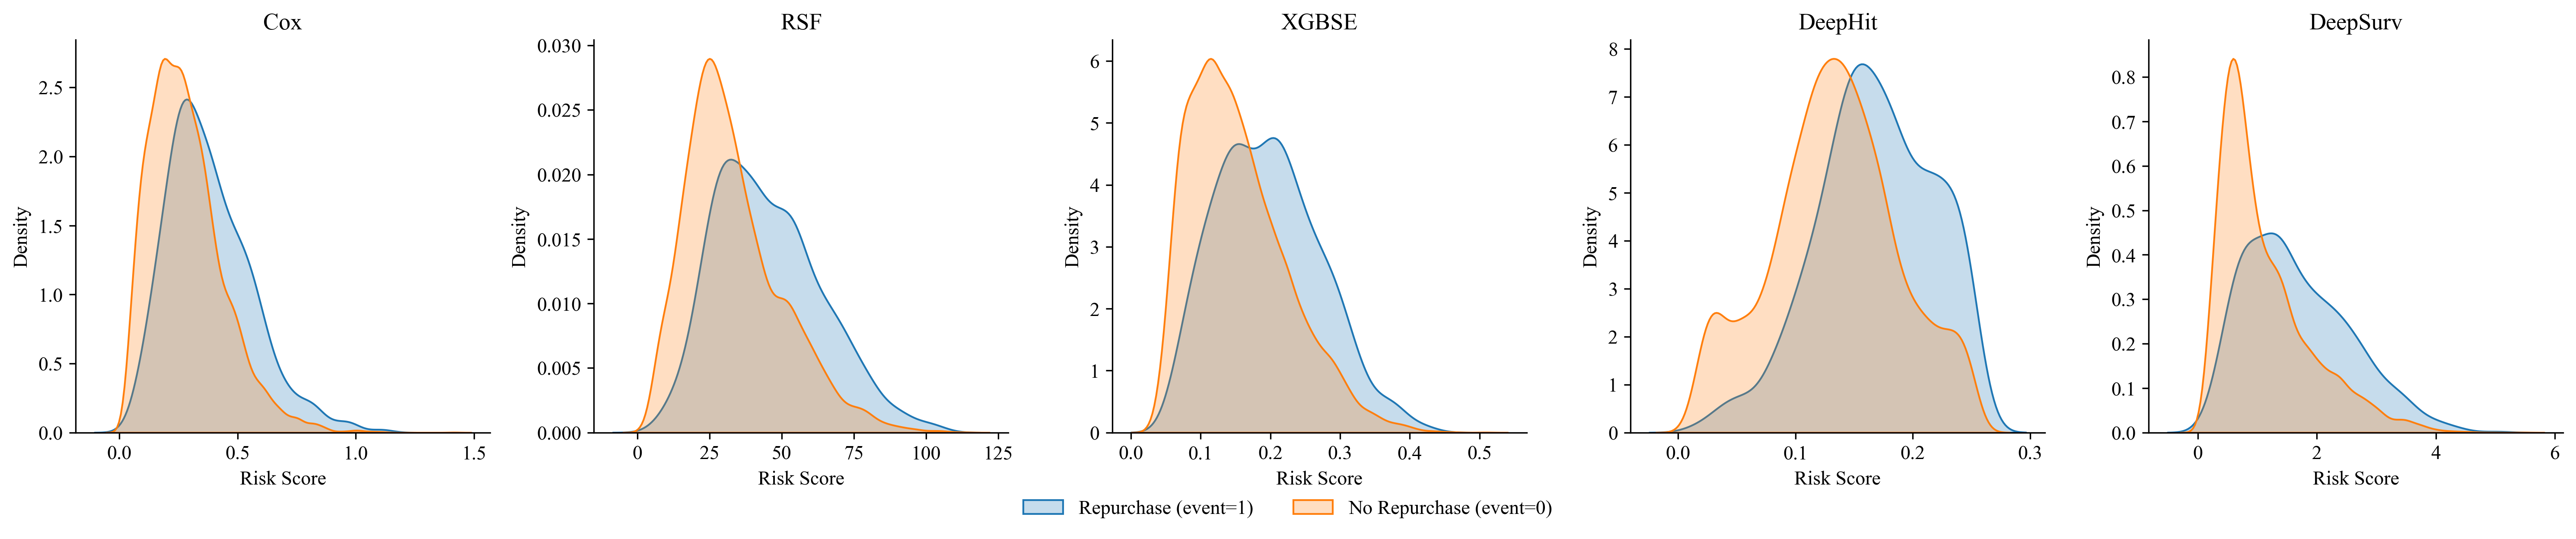

In [353]:
# risk score distributions
# KDE plots comparing risk score distributions for repurchase (event==1) vs non-repurchase (event==0)

model_names = [
    ("Cox", cox_test_risks_exp),
    ("RSF", rsf_test_risks),
    ("XGBSE", xgbse_test_risks_window),
    ("DeepHit", deephit_test_surv_df_risks),
    ("DeepSurv", deepsurv_test_risks_exp)
]

event = y_test['event'].values

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (name, risks) in enumerate(model_names):
    ax = axes[i]
    # Convert to numpy array for indexing
    risks_np = np.asarray(risks)
    sns.kdeplot(risks_np[event == 1], label="Repurchase (event=1)", fill=True, color="tab:blue", ax=ax)
    sns.kdeplot(risks_np[event == 0], label="No Repurchase (event=0)", fill=True, color="tab:orange", ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Risk Score")
    ax.set_ylabel("Density")

# Add a single legend below the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout()
plt.show()



In [354]:
print("=== Risk Score Statistics for All Models ===")
print()

print(f"Cox Risk score std: {cox_test_risks.std():.6f}")
print(f"Cox Risk score range: {cox_test_risks.max() - cox_test_risks.min():.6f}")

print()

print(f"RSF Risk score std: {rsf_test_risks.std():.6f}")
print(f"RSF Risk score range: {rsf_test_risks.max() - rsf_test_risks.min():.6f}")

print()

print(f"XGBSE Risk score std: {xgbse_test_risks_window.std():.6f}")
print(f"XGBSE Risk score range: {xgbse_test_risks_window.max() - xgbse_test_risks_window.min():.6f}")

print()

print(f"DeepHit Risk score std: {deephit_test_surv_df_risks.std():.6f}")
print(f"DeepHit Risk score range: {deephit_test_surv_df_risks.max() - deephit_test_surv_df_risks.min():.6f}")

print()

print(f"DeepSurv Risk score std: {deepsurv_test_risks.std():.6f}")
print(f"DeepSurv Risk score range: {deepsurv_test_risks.max() - deepsurv_test_risks.min():.6f}")


=== Risk Score Statistics for All Models ===

Cox Risk score std: 0.610876
Cox Risk score range: 4.496360

RSF Risk score std: 17.194470
RSF Risk score range: 111.426960

XGBSE Risk score std: 0.071305
XGBSE Risk score range: 0.475191

DeepHit Risk score std: 0.055052
DeepHit Risk score range: 0.251303

DeepSurv Risk score std: 0.688265
DeepSurv Risk score range: 4.654391


In [46]:
# td-auc plots / td-roc plots (90, 180, 360)

/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning:

Approximating using linear interpolation`.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning:

Approximating using linear interpolation`.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning:

Approximating using linear interpolation`.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning:

Approximating using linear interpolation`.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning:

Approximating using linear interpolation`.


/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning:

Approximating using

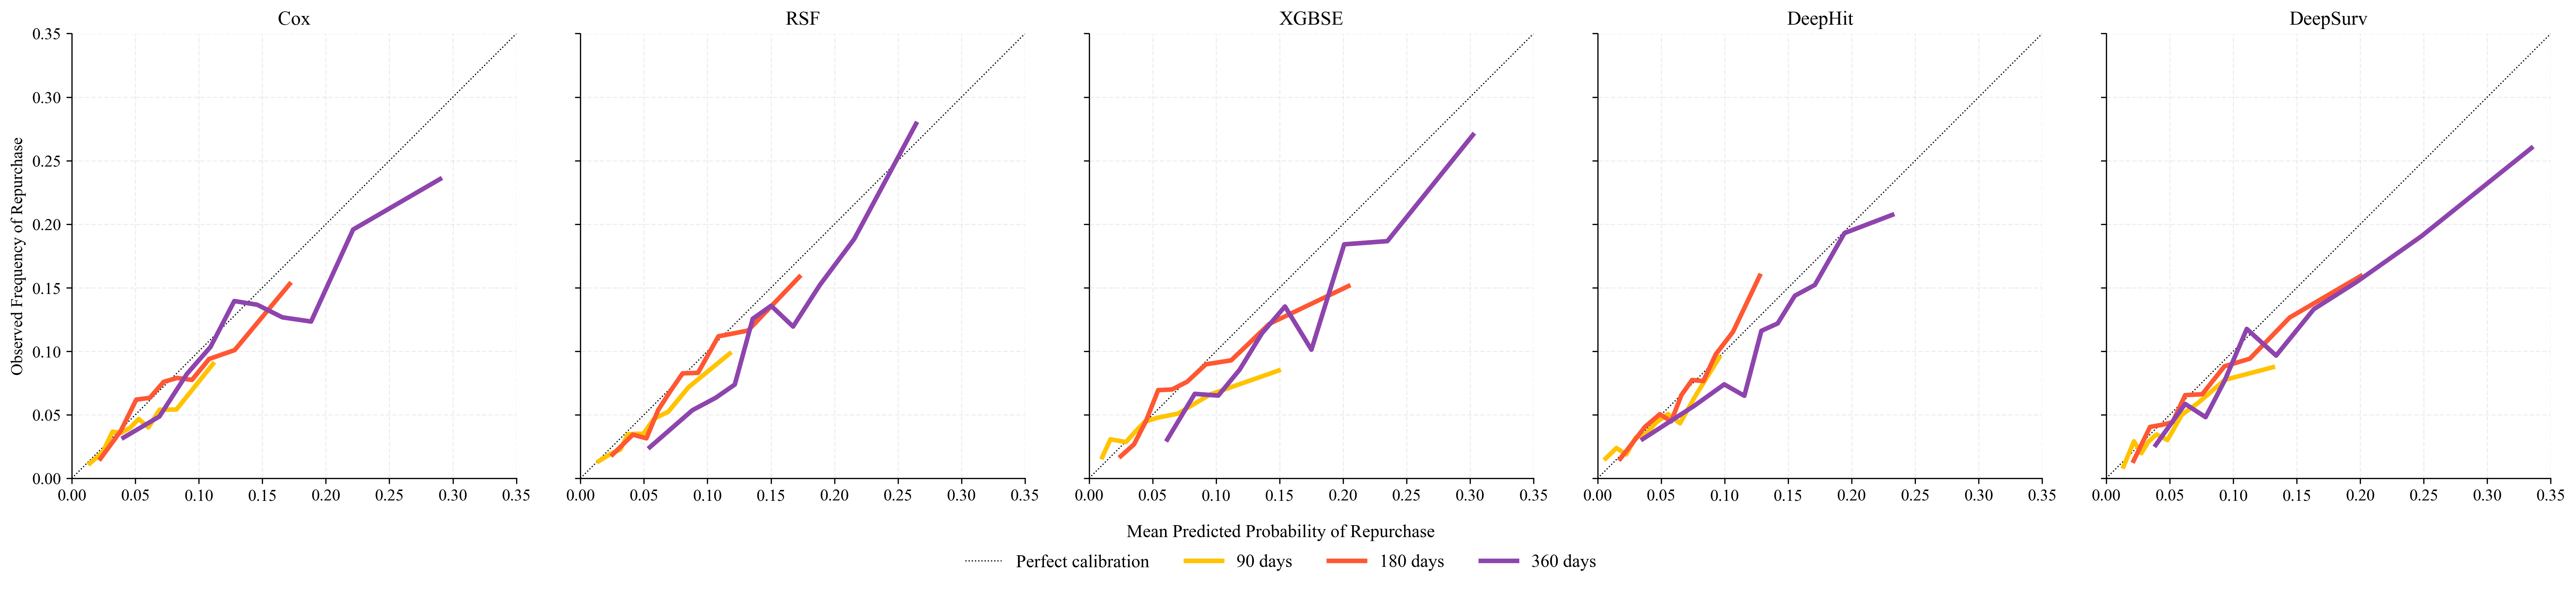

In [317]:
from lifelines import KaplanMeierFitter

def plot_calibration_on_ax(ax, model_name, predictions, pred_type, y_test_data, is_first_plot=False):
    """
    Plots the calibration curve for a single model on a given matplotlib axis.
    
    Args:
        ax: The matplotlib axis to plot on.
        model_name (str): The name of the model for the title.
        predictions: The prediction object from the model.
        pred_type (str): Type of prediction object ('funcs', 'df', 'df_transposed').
        y_test_data: DataFrame with 'time' and 'event' columns.
    """
    time_points = [90, 180, 360]
    colors = ['#FFC300',       '#FF5733',        '#8E44AD']
    linestyles = ['-', '-', '-']
    
    diag_label = 'Perfect Calibration' if is_first_plot else '_nolegend_'
    ax.plot([0, 1], [0, 1], 'k', linestyle=':', label='Perfect calibration', linewidth=0.8)

    for i, t0 in enumerate(time_points):
        # --- Get survival probabilities based on prediction type ---
        if pred_type == 'funcs':
            survival_probs_at_t0 = np.array([fn(t0) for fn in predictions])
        elif pred_type == 'df':
            survival_probs_at_t0 = predictions[float(t0) if float(t0) in predictions.columns else int(t0)]
        elif pred_type == 'df_transposed':
            survival_probs_at_t0 = predictions.T[float(t0)]
        
        event_probs_at_t0 = 1 - survival_probs_at_t0
        
        # --- Standard calculation logic ---
        cal_df = pd.DataFrame({
            'predicted_prob': event_probs_at_t0,
            'time': y_test_data['time'],
            'event': y_test_data['event']
        })
        try:
            cal_df['prob_bin'] = pd.qcut(cal_df['predicted_prob'], q=10, labels=False, duplicates='drop')
        except ValueError:
            cal_df['prob_bin'] = pd.cut(cal_df['predicted_prob'], bins=10, labels=False, include_lowest=True)
        
        binned_groups = cal_df.groupby('prob_bin')
        mean_predicted_prob = binned_groups['predicted_prob'].mean()
        
        observed_frequency = []
        for name, group in binned_groups:
            kmf = KaplanMeierFitter()
            kmf.fit(group['time'], event_observed=group['event'])
            observed_frequency.append(1 - kmf.predict(t0, interpolate=True))

        # --- Plotting ---
        sorted_indices = mean_predicted_prob.argsort()
        ax.plot(mean_predicted_prob.iloc[sorted_indices], pd.Series(observed_frequency).iloc[sorted_indices],
                c=colors[i],
                linestyle=linestyles[i],
                linewidth=3,
                label=f'{t0} days')

    # --- Formatting for each subplot ---
    upper_limit = 0.35
    ax.set_xlim(0, upper_limit)
    ax.set_ylim(0, upper_limit)
    ax.set_title(f'{model_name}')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', alpha=0.2)
    
# ==============================================================================
# === 4. CREATE THE FIGURE AND PLOT ALL MODELS =================================
# ==============================================================================

# Create a figure with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(24, 5), sharey=True)

# --- Define our models, their predictions, and prediction types ---
models_to_plot = [
    ('Cox', cox_surv_funcs, 'funcs'),
    ('RSF', rsf_surv_funcs, 'funcs'),
    ('XGBSE', xgbse_test_survival_probs, 'df'),
    ('DeepHit', deephit_test_surv_df, 'df'),
    ('DeepSurv', deepsurv_test_surv_df, 'df_transposed')
]

# --- Loop through models and plot on respective axes ---
for i, (model_name, preds, pred_type) in enumerate(models_to_plot):
    plot_calibration_on_ax(axes[i], model_name, preds, pred_type, y_test, is_first_plot=(i==0))

# --- Final Figure Formatting ---
# Set a shared y-axis label
axes[0].set_ylabel('Observed Frequency of Repurchase')
# Set a shared x-axis label in the middle
fig.text(0.5, 0.05, 'Mean Predicted Probability of Repurchase', ha='center', va='center', fontsize=12)

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend at the bottom
plt.show()

Calculating cumulative/dynamic AUC over time for all models...
Calculation complete.


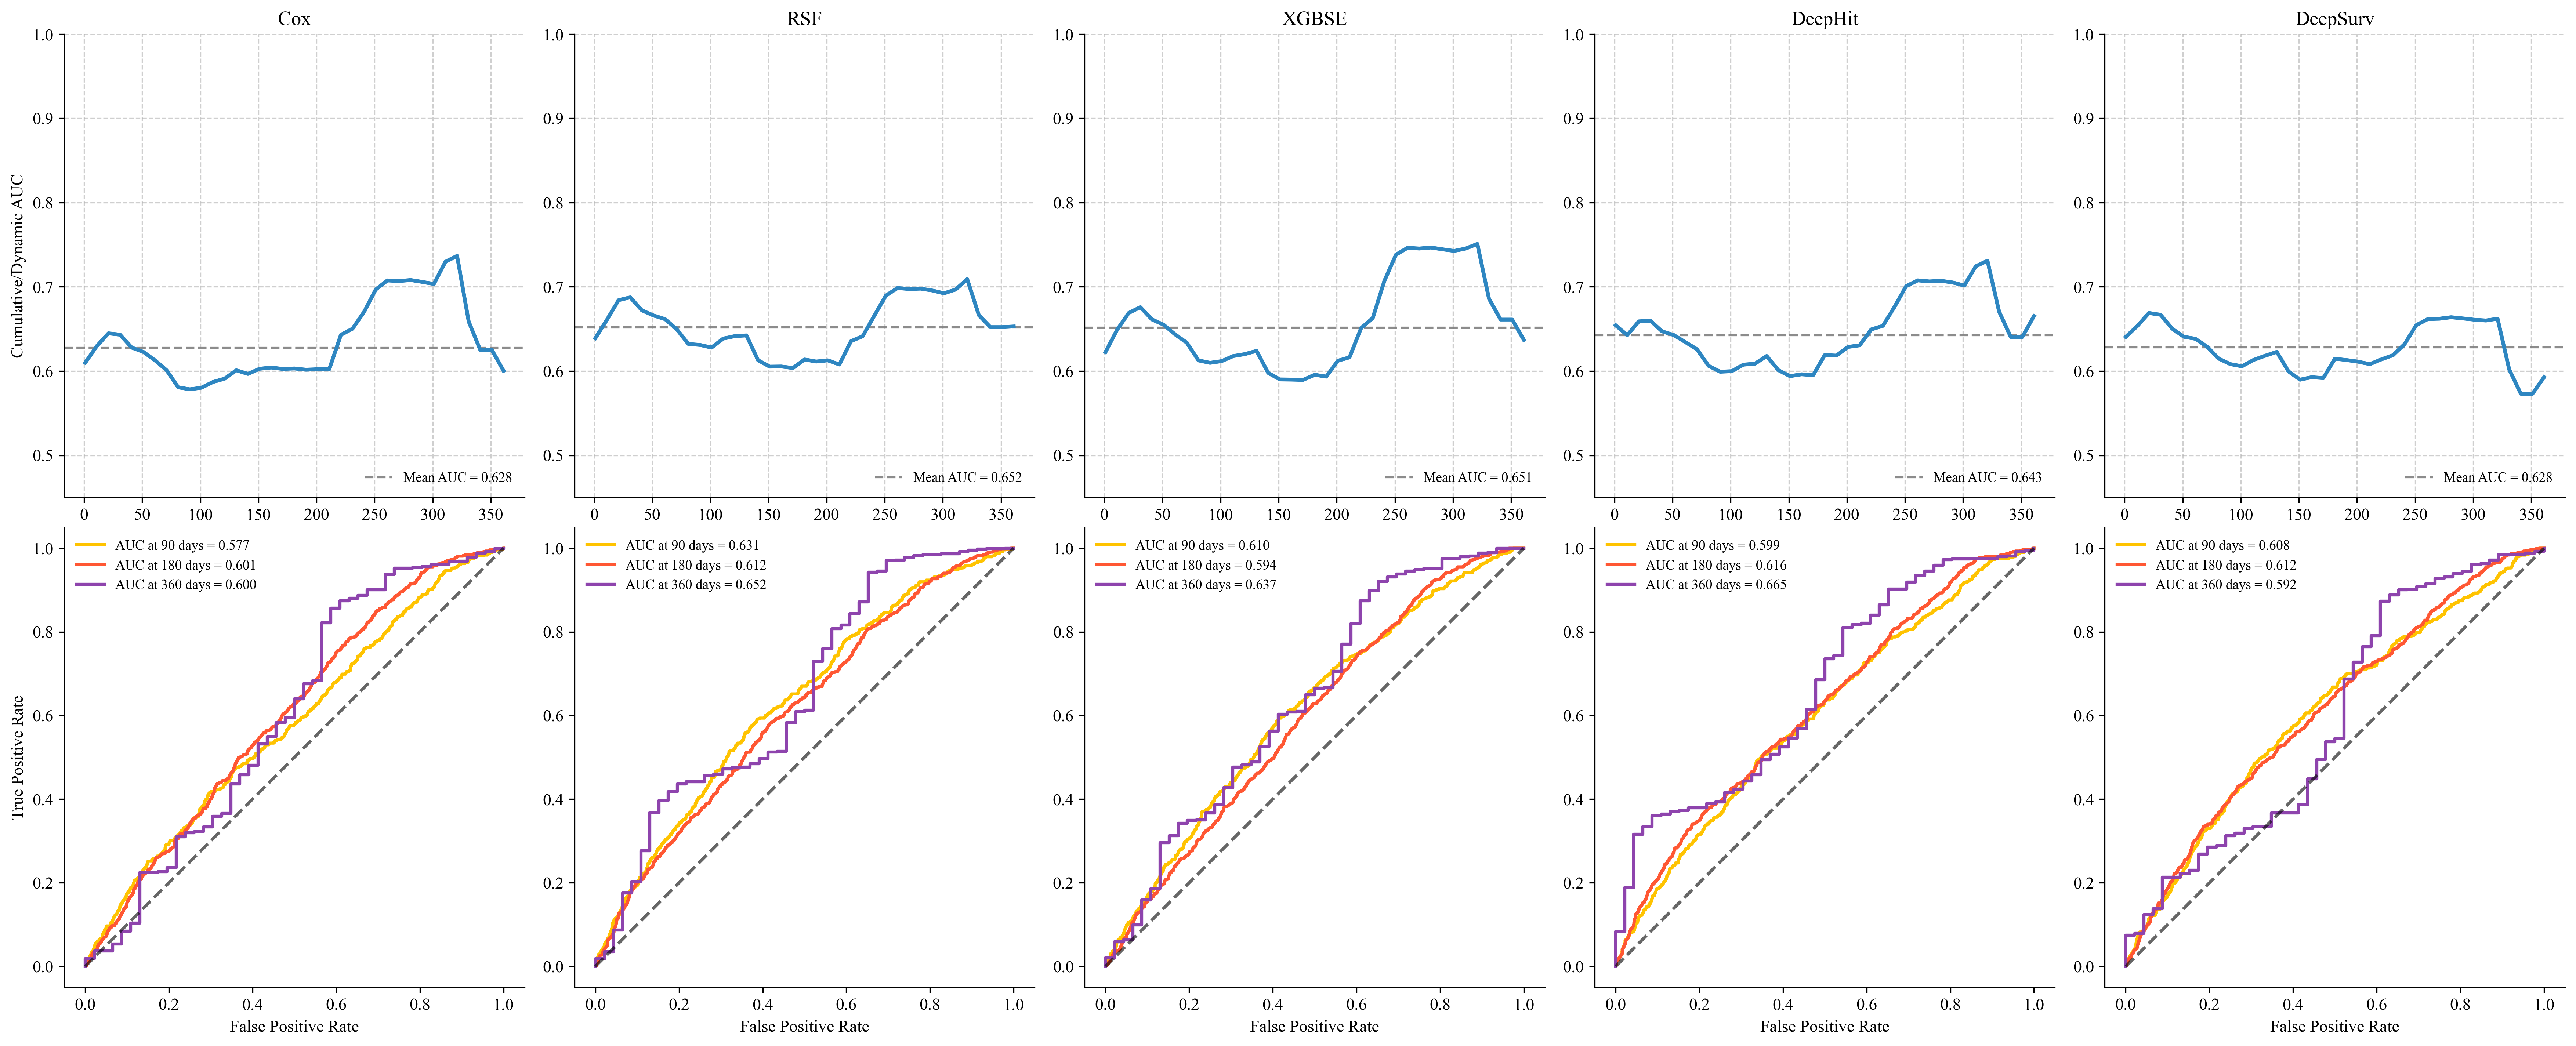

In [201]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

ROC_COLORS = ['#FFC300',       '#FF5733',        '#8E44AD']

models_to_plot = [
    ('Cox', cox_test_risks), 
    ('RSF', rsf_test_risks),
    ('XGBSE', xgbse_test_risks), 
    ('DeepHit', deephit_test_risks),
    ('DeepSurv', deepsurv_test_risks)
]

# Pre-calculate all AUC curves and mean values
evaluation_times = np.arange(int(y_test['time'].min()), int(y_test['time'].max()), 10)
all_auc_scores = pd.DataFrame(index=evaluation_times)
mean_aucs = {}

print("Calculating cumulative/dynamic AUC over time for all models...")
for model_name, risks in models_to_plot:
    auc_curve, integrated_mean_auc = cumulative_dynamic_auc(
        survival_train=y_train_struct, survival_test=y_test_struct,
        estimate=risks, times=evaluation_times
    )
    all_auc_scores[model_name] = auc_curve
    mean_aucs[model_name] = integrated_mean_auc
print("Calculation complete.")

# ==============================================================================
# === 4. HELPER FUNCTION FOR ROC SNAPSHOTS =====================================
# ==============================================================================
def time_dependent_roc_at_t(y_true, risk_scores, time_point):
    events_by_t = (y_true['time'] <= time_point) & (y_true['event'] == 1)
    no_events_by_t = y_true['time'] > time_point
    if events_by_t.sum() == 0 or no_events_by_t.sum() == 0: return np.array([0, 1]), np.array([0, 1])
    y_true_binary = np.concatenate([np.ones(events_by_t.sum()), np.zeros(no_events_by_t.sum())])
    y_scores_binary = np.concatenate([risk_scores[events_by_t], risk_scores[no_events_by_t]])
    return roc_curve(y_true_binary, y_scores_binary)

# ==============================================================================
# === 5. CREATE THE 2x5 FIGURE =================================================
# ==============================================================================
fig, axes = plt.subplots(2, 5, figsize=(24, 10), sharex=False, sharey=False)

for i, (model_name, risks) in enumerate(models_to_plot):
    # --- Define the axes for this model ---
    ax_top = axes[0, i]
    ax_bottom = axes[1, i]
    
    # --- Plot 1: AUC Over Time (Top Row) ---
    model_mean_auc = mean_aucs[model_name]
    ax_top.axhline(model_mean_auc, color='gray', linestyle='--', linewidth=1.5, alpha=0.9,
                   label=f'Mean AUC = {model_mean_auc:.3f}')
    ax_top.plot(evaluation_times, all_auc_scores[model_name], color=COLORS[0], linewidth=2.5)
    ax_top.set_title(model_name)
    ax_top.grid(True, linestyle='--', alpha=0.6)
    ax_top.legend(loc='lower right', fontsize=9)
    ax_top.set_ylim(0.45, 1.0)

    # --- Plot 2: ROC Curves (Bottom Row) ---
    time_points = [90, 180, 360]
    for j, t in enumerate(time_points):
        fpr, tpr, _ = time_dependent_roc_at_t(y_test, risks, t)
        auc_score = auc(fpr, tpr)
        ax_bottom.plot(fpr, tpr, color=ROC_COLORS[j], label=f'AUC at {t} days = {auc_score:.3f}', lw=2)
    
    ax_bottom.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    ax_bottom.set_aspect('equal', adjustable='box')
    ax_bottom.legend(fontsize=9)
    #ax_bottom.grid(True, linestyle='--', alpha=0.5)

# --- Final Figure Formatting ---
# Set shared labels for rows and columns
for i in range(5):
    axes[1, i].set_xlabel('False Positive Rate') # Label bottom row
    axes[0, i].sharey(axes[0, 0]) # Share Y-axis for top row
    axes[1, i].sharey(axes[1, 0]) # Share Y-axis for bottom row
    axes[1, i].sharex(axes[1, 0]) # Share X-axis for bottom row

axes[0, 0].set_ylabel('Cumulative/Dynamic AUC')
axes[1, 0].set_ylabel('True Positive Rate')

# Adjust layout
plt.tight_layout(rect=[0.02, 0.0, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()

## Model explainability

In [ ]:
import pandas as pd
import survshap
from survshap import SurvivalModelExplainer, ModelSurvSHAP
from sksurv.util import Surv

def stratified_sample(X, y, n_samples=150, random_state=42):
    event_rate = y['event'].mean()
    n_event_1 = int(n_samples * event_rate)
    n_event_0 = n_samples - n_event_1
    
    indices_1 = X[y['event'] == 1].index
    indices_0 = X[y['event'] == 0].index
    
    sample_1 = X.loc[indices_1].sample(n=min(n_event_1, len(indices_1)), random_state=random_state)
    sample_0 = X.loc[indices_0].sample(n=min(n_event_0, len(indices_0)), random_state=random_state)
    
    return pd.concat([sample_1, sample_0])

# Sample data
X_train_sample = stratified_sample(X_train, y_train, n_samples=150)
X_test_sample = stratified_sample(X_test, y_test, n_samples=150)

# Convert to structured arrays
y_train_sample = Surv.from_arrays(
    y_train.loc[X_train_sample.index, 'event'].astype(bool),
    y_train.loc[X_train_sample.index, 'time']
)

y_test_sample = Surv.from_arrays(
    y_test.loc[X_test_sample.index, 'event'].astype(bool),
    y_test.loc[X_test_sample.index, 'time']
)

# Create explainer and fit
explainer = SurvivalModelExplainer(
    model=rsf_model, 
    data=X_train_sample, 
    y=y_train_sample
)

rsf_model_survshap = ModelSurvSHAP(calculation_method="sampling", B=20, random_state=1212)
rsf_model_survshap.fit(explainer=explainer, new_observations=X_test_sample)
print("ModelSurvSHAP fitted successfully!")

/Users/bing/Documents/survival/survenv/lib/python3.11/site-packages/survshap/model_explanations/object.py:62: UserWarning: Using 150 background data samples could cause slower run times.
Consider using a smaller sample.
  warnings.warn(
100%|██████████| 150/150 [50:30<00:00, 20.21s/it]


ModelSurvSHAP fitted successfully!


In [247]:
type(rsf_model_survshap.result)

pandas.core.frame.DataFrame

In [358]:
X_train.shape

(59702, 52)

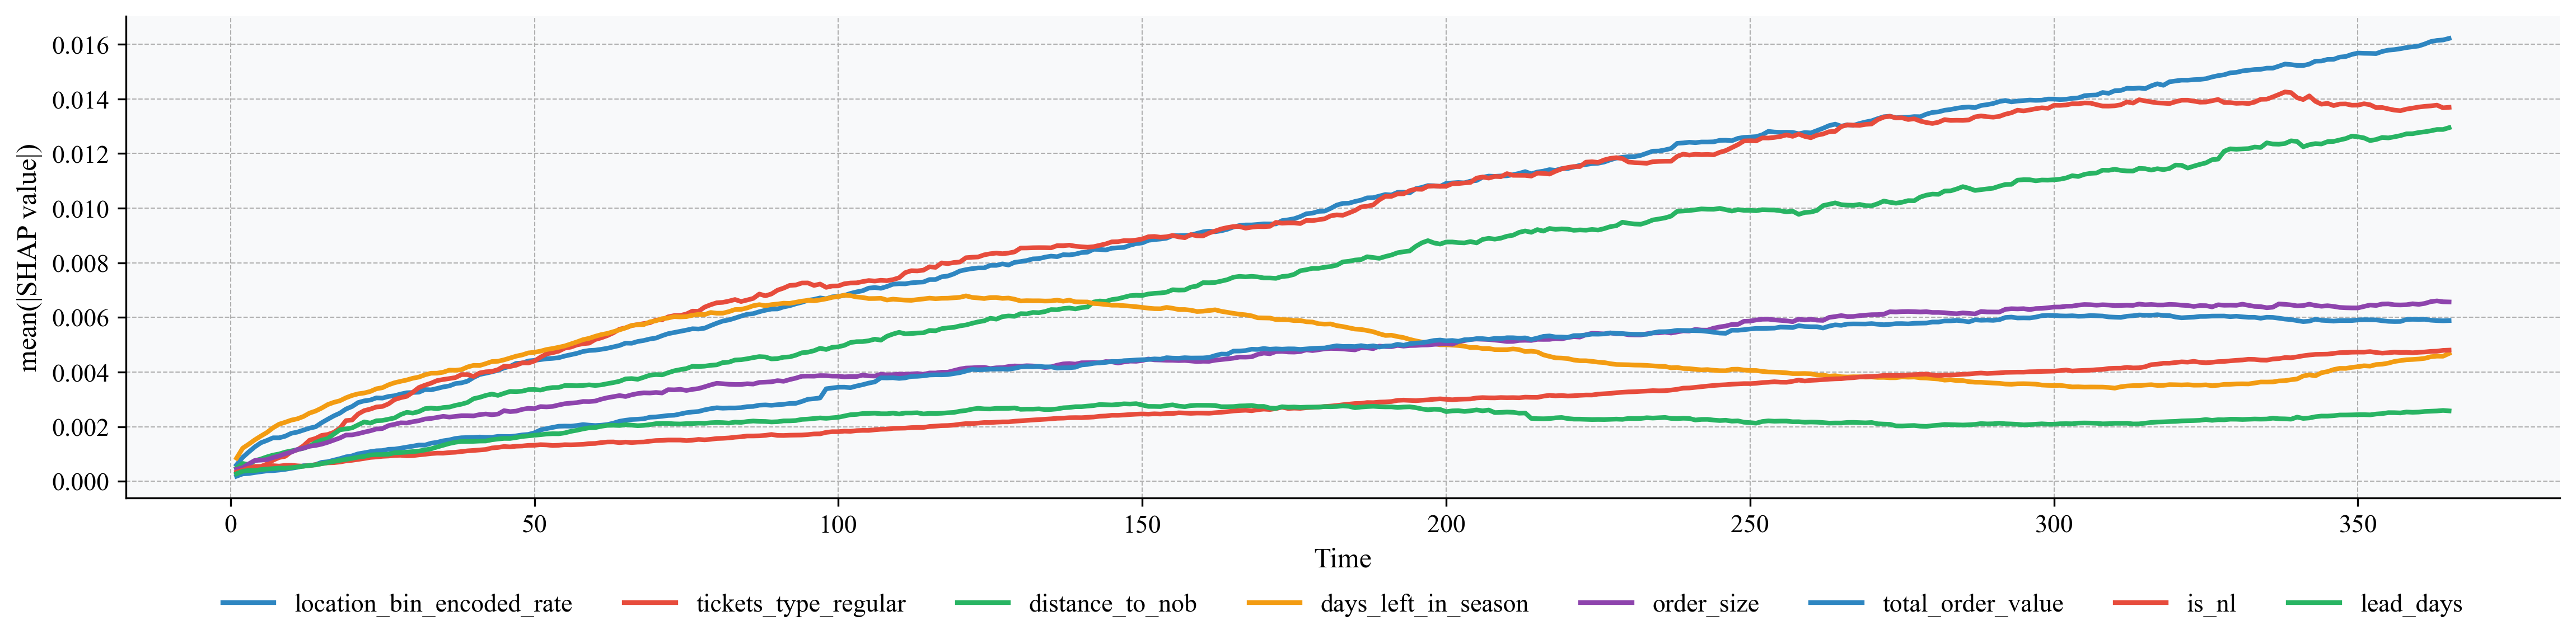

In [254]:
max_vars = 8

# --- 2. Data Preparation ---

# Select the top 'max_vars' features (the dataframe is already sorted)
df_to_plot = rsf_model_survshap.result.head(max_vars)

# Find all columns that represent time points
time_cols = [col for col in df_to_plot.columns if col.startswith('t = ')]

# Extract the time values (x-axis) from the column names
time_values = [float(col.split('=')[1]) for col in time_cols]

# --- 3. Plotting ---

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(16, 4))

# Loop through each feature in the prepared DataFrame and plot its line
for index, row in df_to_plot.iterrows():
    feature_name = row['variable_name']
    shap_values = row[time_cols].values
    
    ax.plot(time_values, shap_values, label=feature_name)

# --- 4. Customization ---

# Add a title and axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('mean(|SHAP value|)', fontsize=12)

# Add a legend to identify the lines
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, 
    shadow=True, 
    ncol=8
)

# Add a grid for better readability, similar to the original plot
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set the background color
ax.set_facecolor('#f8f9fa')
fig.set_facecolor('white')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()

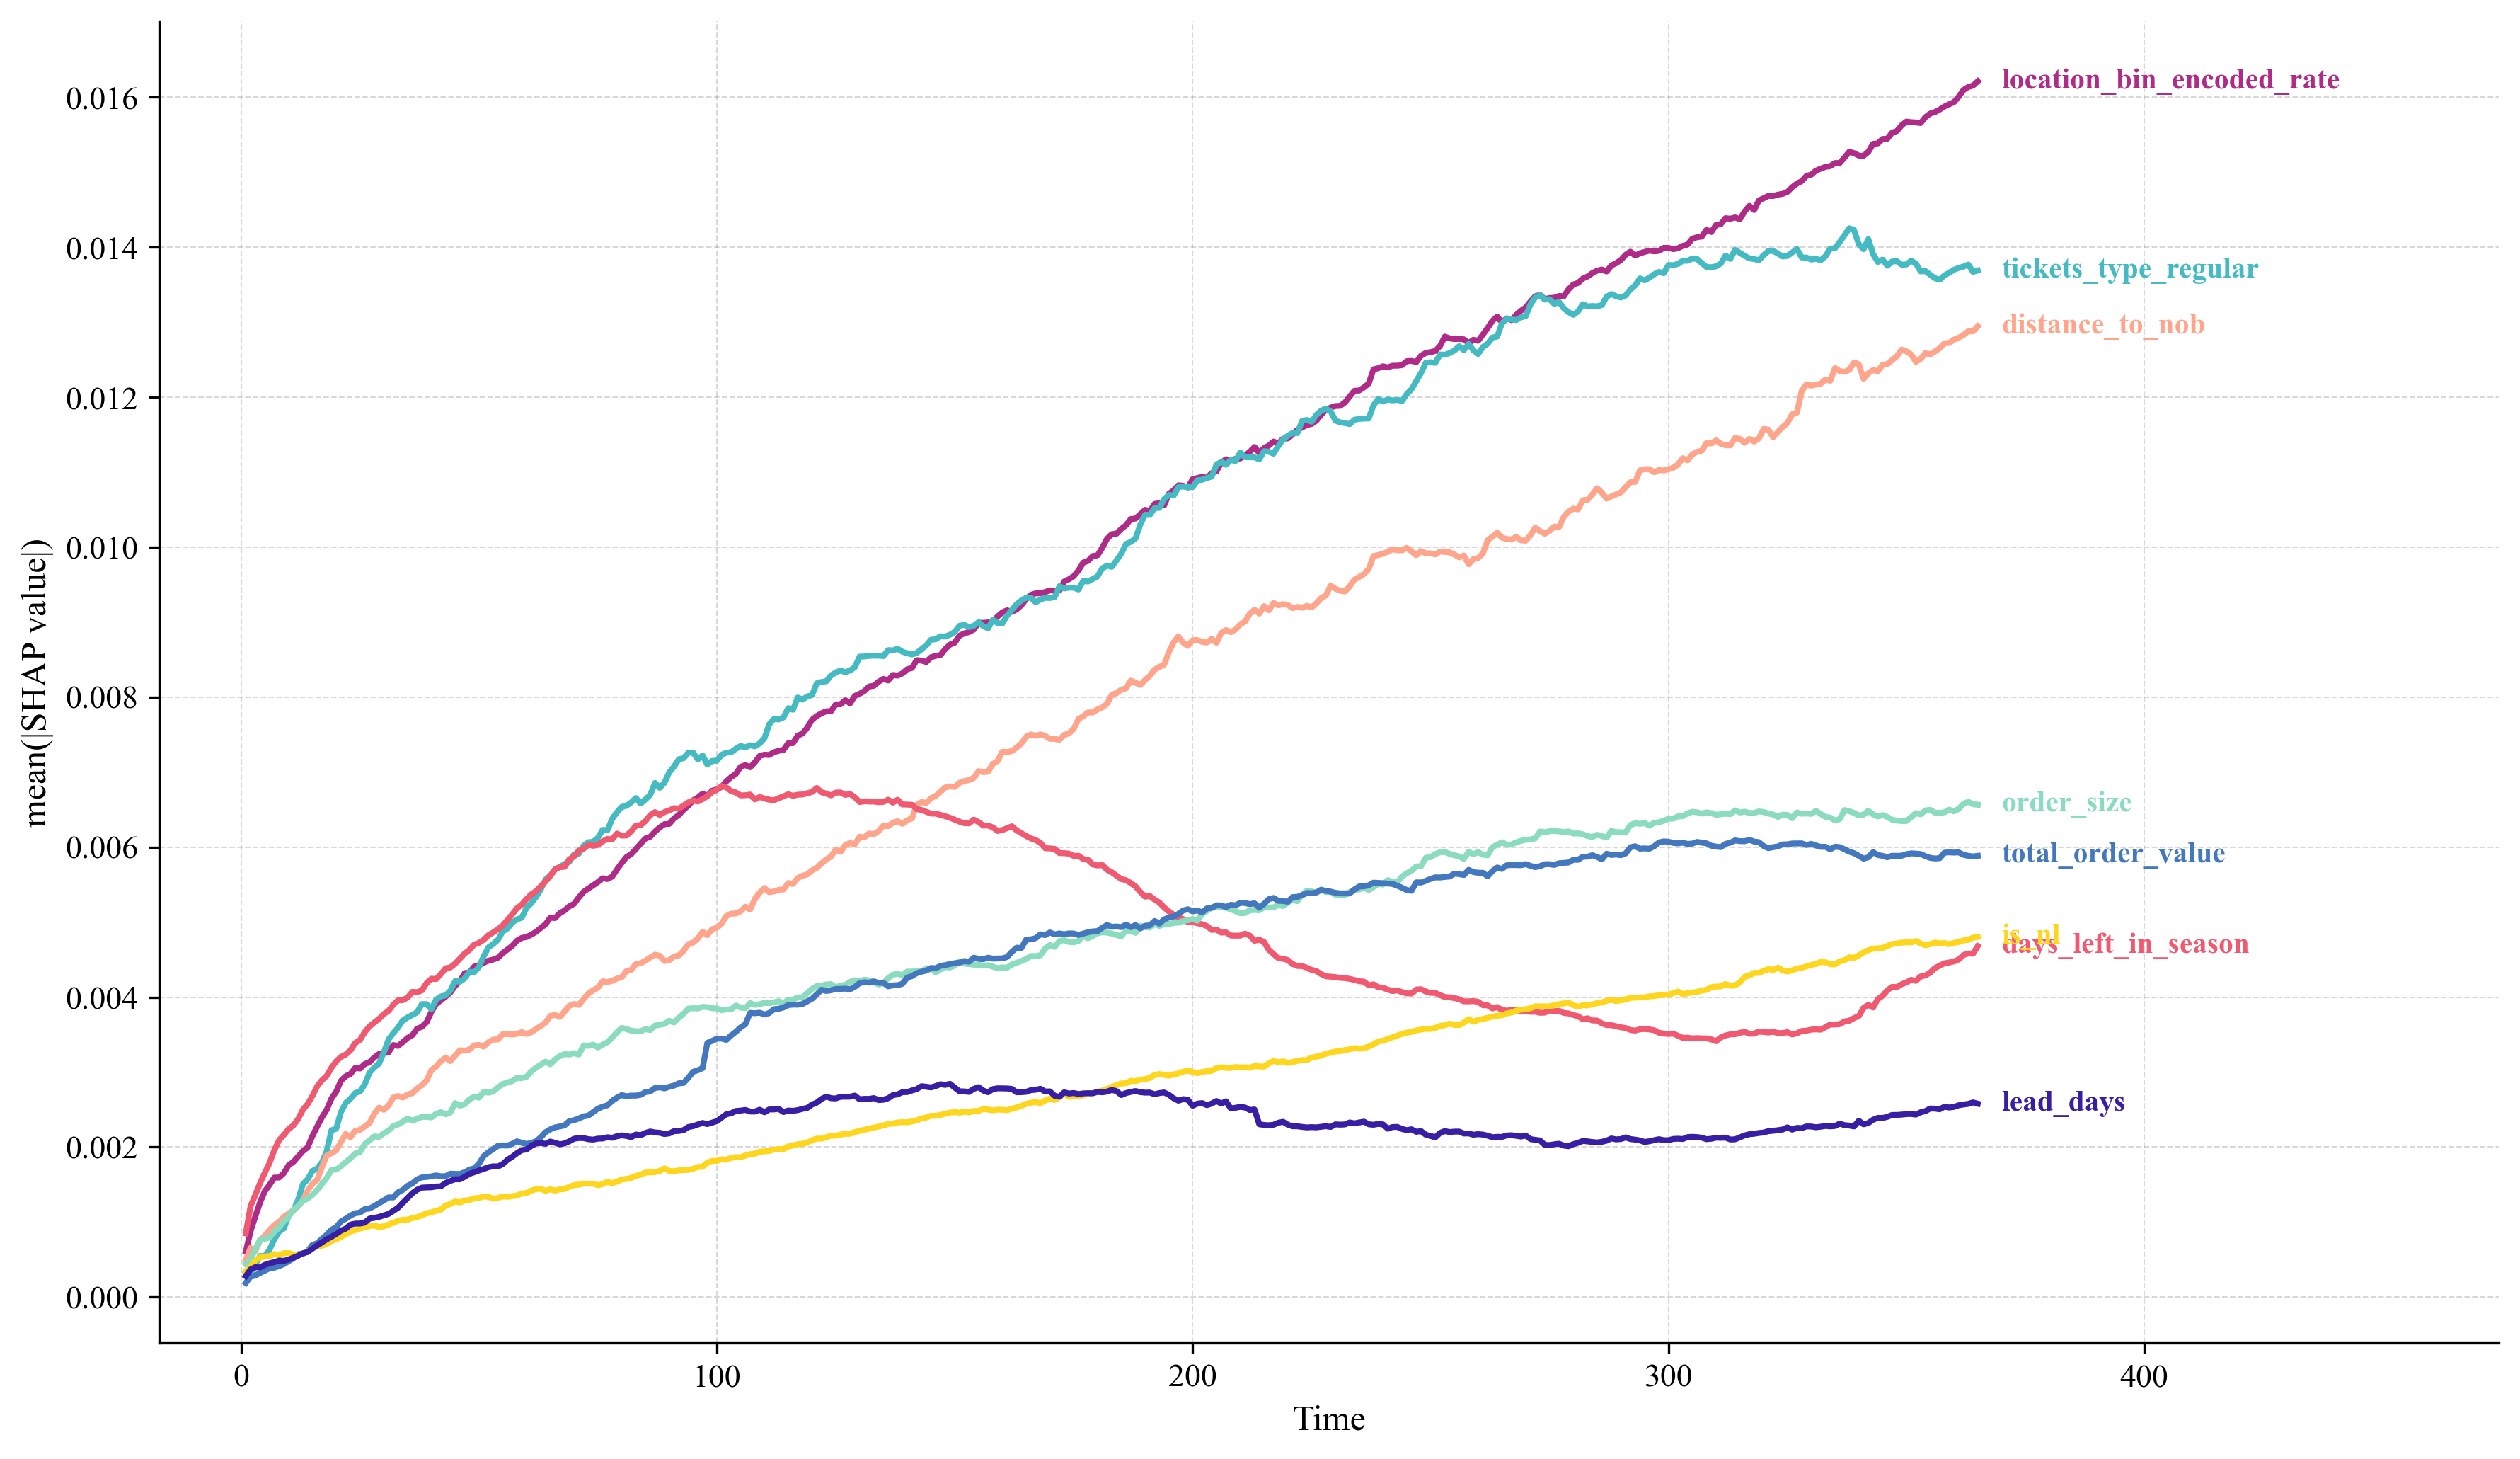

In [277]:
max_vars = 8
df_to_plot = rsf_model_survshap.result.head(max_vars)
time_cols = [col for col in df_to_plot.columns if col.startswith('t = ')]
time_values = [float(col.split('=')[1]) for col in time_cols]

# --- 3. Plotting (with Enhanced Styling) ---

# MODIFICATION: Define a professional color palette
colors = ['#ae2c87', '#46bac2', '#ffa58c', '#f05a71', '#8bdcbe', '#4378bf', '#FED61E', '#371ea3']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 7))

# Loop through each feature to plot and directly label the lines
for i, (index, row) in enumerate(df_to_plot.iterrows()):
    feature_name = row['variable_name']
    shap_values = row[time_cols].values
    line_color = colors[i % len(colors)] # Cycle through colors
    
    # Plot the line
    ax.plot(time_values, shap_values, label=feature_name, color=line_color, linewidth=2)
    
    # MODIFICATION: Add direct text label at the end of the line
    ax.text(
        x=time_values[-1] + 5, # Add a small horizontal offset
        y=shap_values[-1],
        s=feature_name,
        color=line_color,
        va='center', # Vertically align text with the line
        ha='left',   # Horizontally align text to start after the line
        fontweight='bold',
        fontsize=10
    )

# --- 4. Customization (MODIFIED) ---



# Set axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('mean(|SHAP value|)', fontsize=12)

# MODIFICATION: Remove the old legend block entirely
# ax.legend(...) is no longer needed

# MODIFICATION: Clean up the aesthetics
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('white')
fig.set_facecolor('white')

# MODIFICATION: Adjust x-axis limit to make space for the direct labels
ax.set_xlim(right=max(time_values) * 1.3) # Extend axis by 30%

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

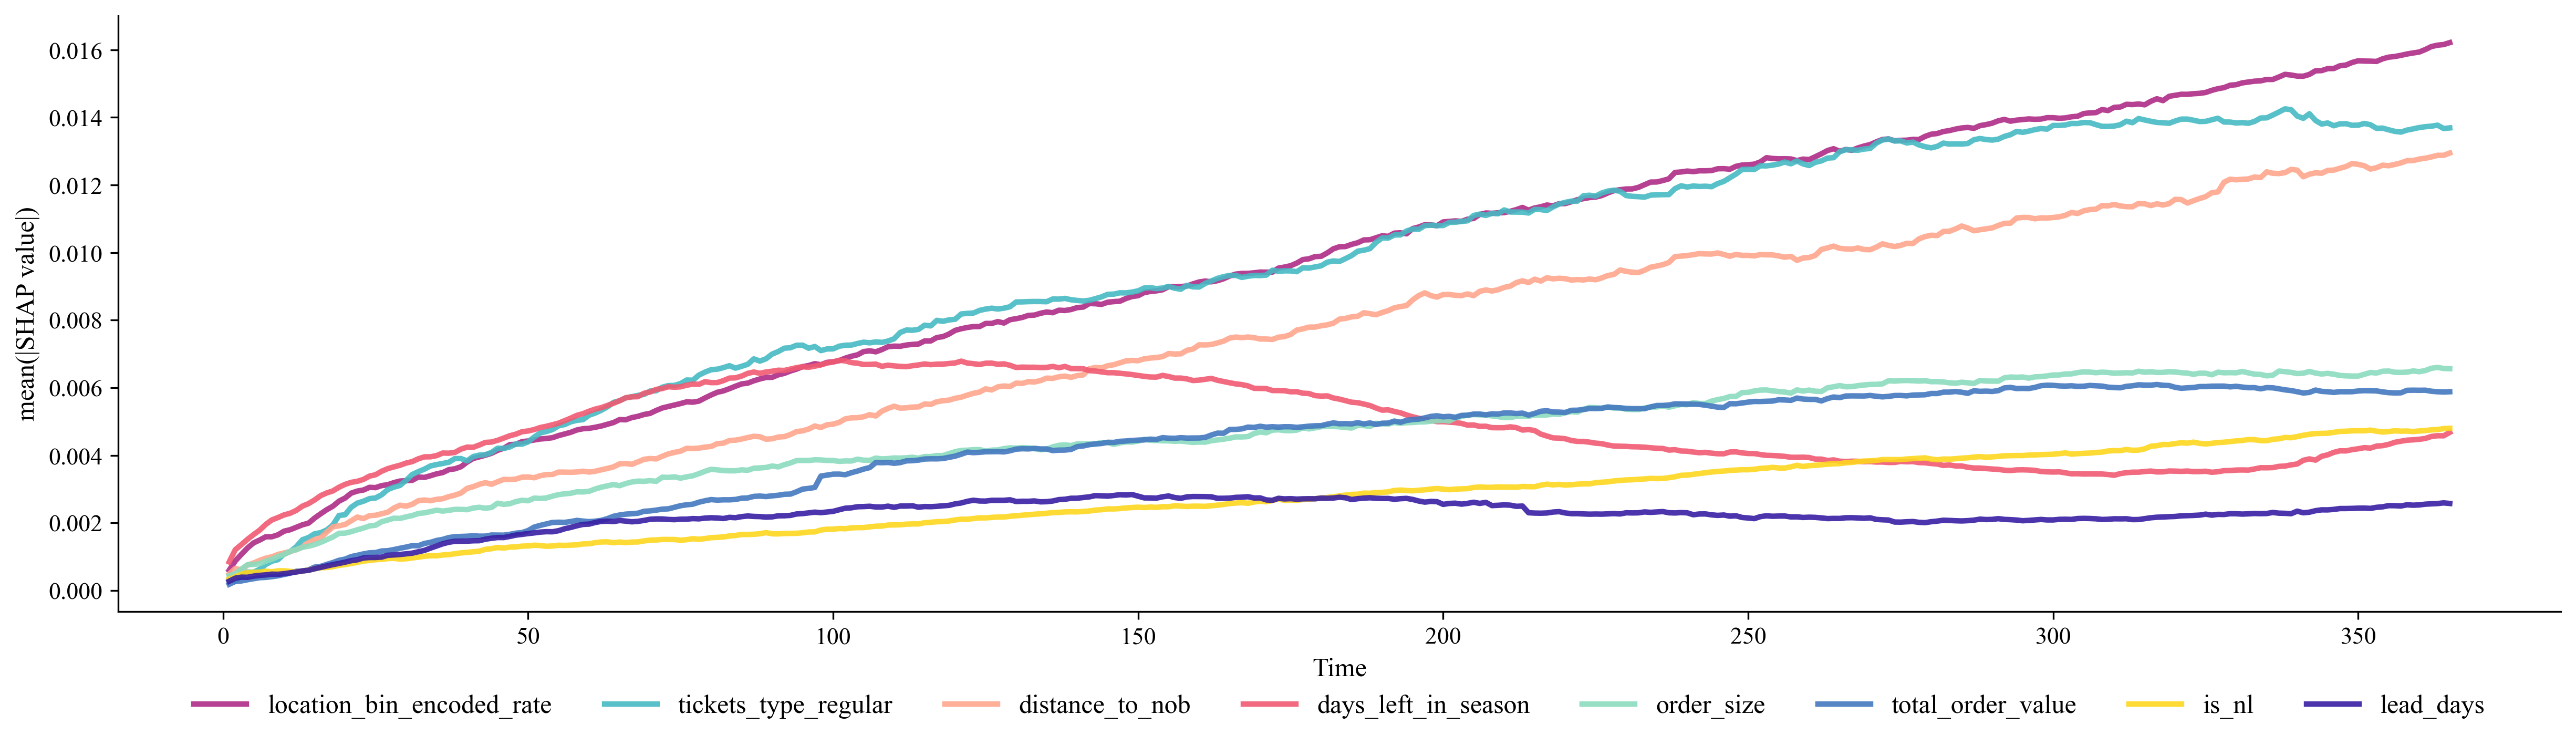

In [ ]:
max_vars = 8
df_to_plot = rsf_model_survshap.result.head(max_vars)
time_cols = [col for col in df_to_plot.columns if col.startswith('t = ')]
time_values = [float(col.split('=')[1]) for col in time_cols]

# --- 3. Plotting with Enhanced Styling ---

# MODIFICATION: Define a professional color palette
colors = ['#ae2c87', '#46bac2', '#ffa58c', '#f05a71', '#8bdcbe', '#4378bf', '#FED61E', '#371ea3']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 6))

# Loop through each feature and plot its line with improved aesthetics
for i, (index, row) in enumerate(df_to_plot.iterrows()):
    feature_name = row['variable_name']
    shap_values = row[time_cols].values
    
    # MODIFICATION: Use refined colors, thicker lines, and slight transparency
    ax.plot(
        time_values, 
        shap_values, 
        label=feature_name, 
        color=colors[i % len(colors)],
        linewidth=2.5, # Make lines more substantial
        alpha=0.9      # Add slight transparency
    )

# --- 4. Customization ---

# Set axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('mean(|SHAP value|)', fontsize=12)

# MODIFICATION: Use an elegant, frameless legend below the plot
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.1), # Position it below the x-axis label
    ncol=8,                   # Arrange in 4 columns
    frameon=False,            # Remove the legend box/frame for a cleaner look
    fontsize=12
)

# MODIFICATION: Clean up grid and spines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
fig.set_facecolor('white')

# MODIFICATION: Adjust layout to make space for the legend at the bottom
plt.subplots_adjust(bottom=0.25)

plt.show()

In [234]:
rsf_model_survshap.plot_mean_abs_shap_values(max_vars=8)

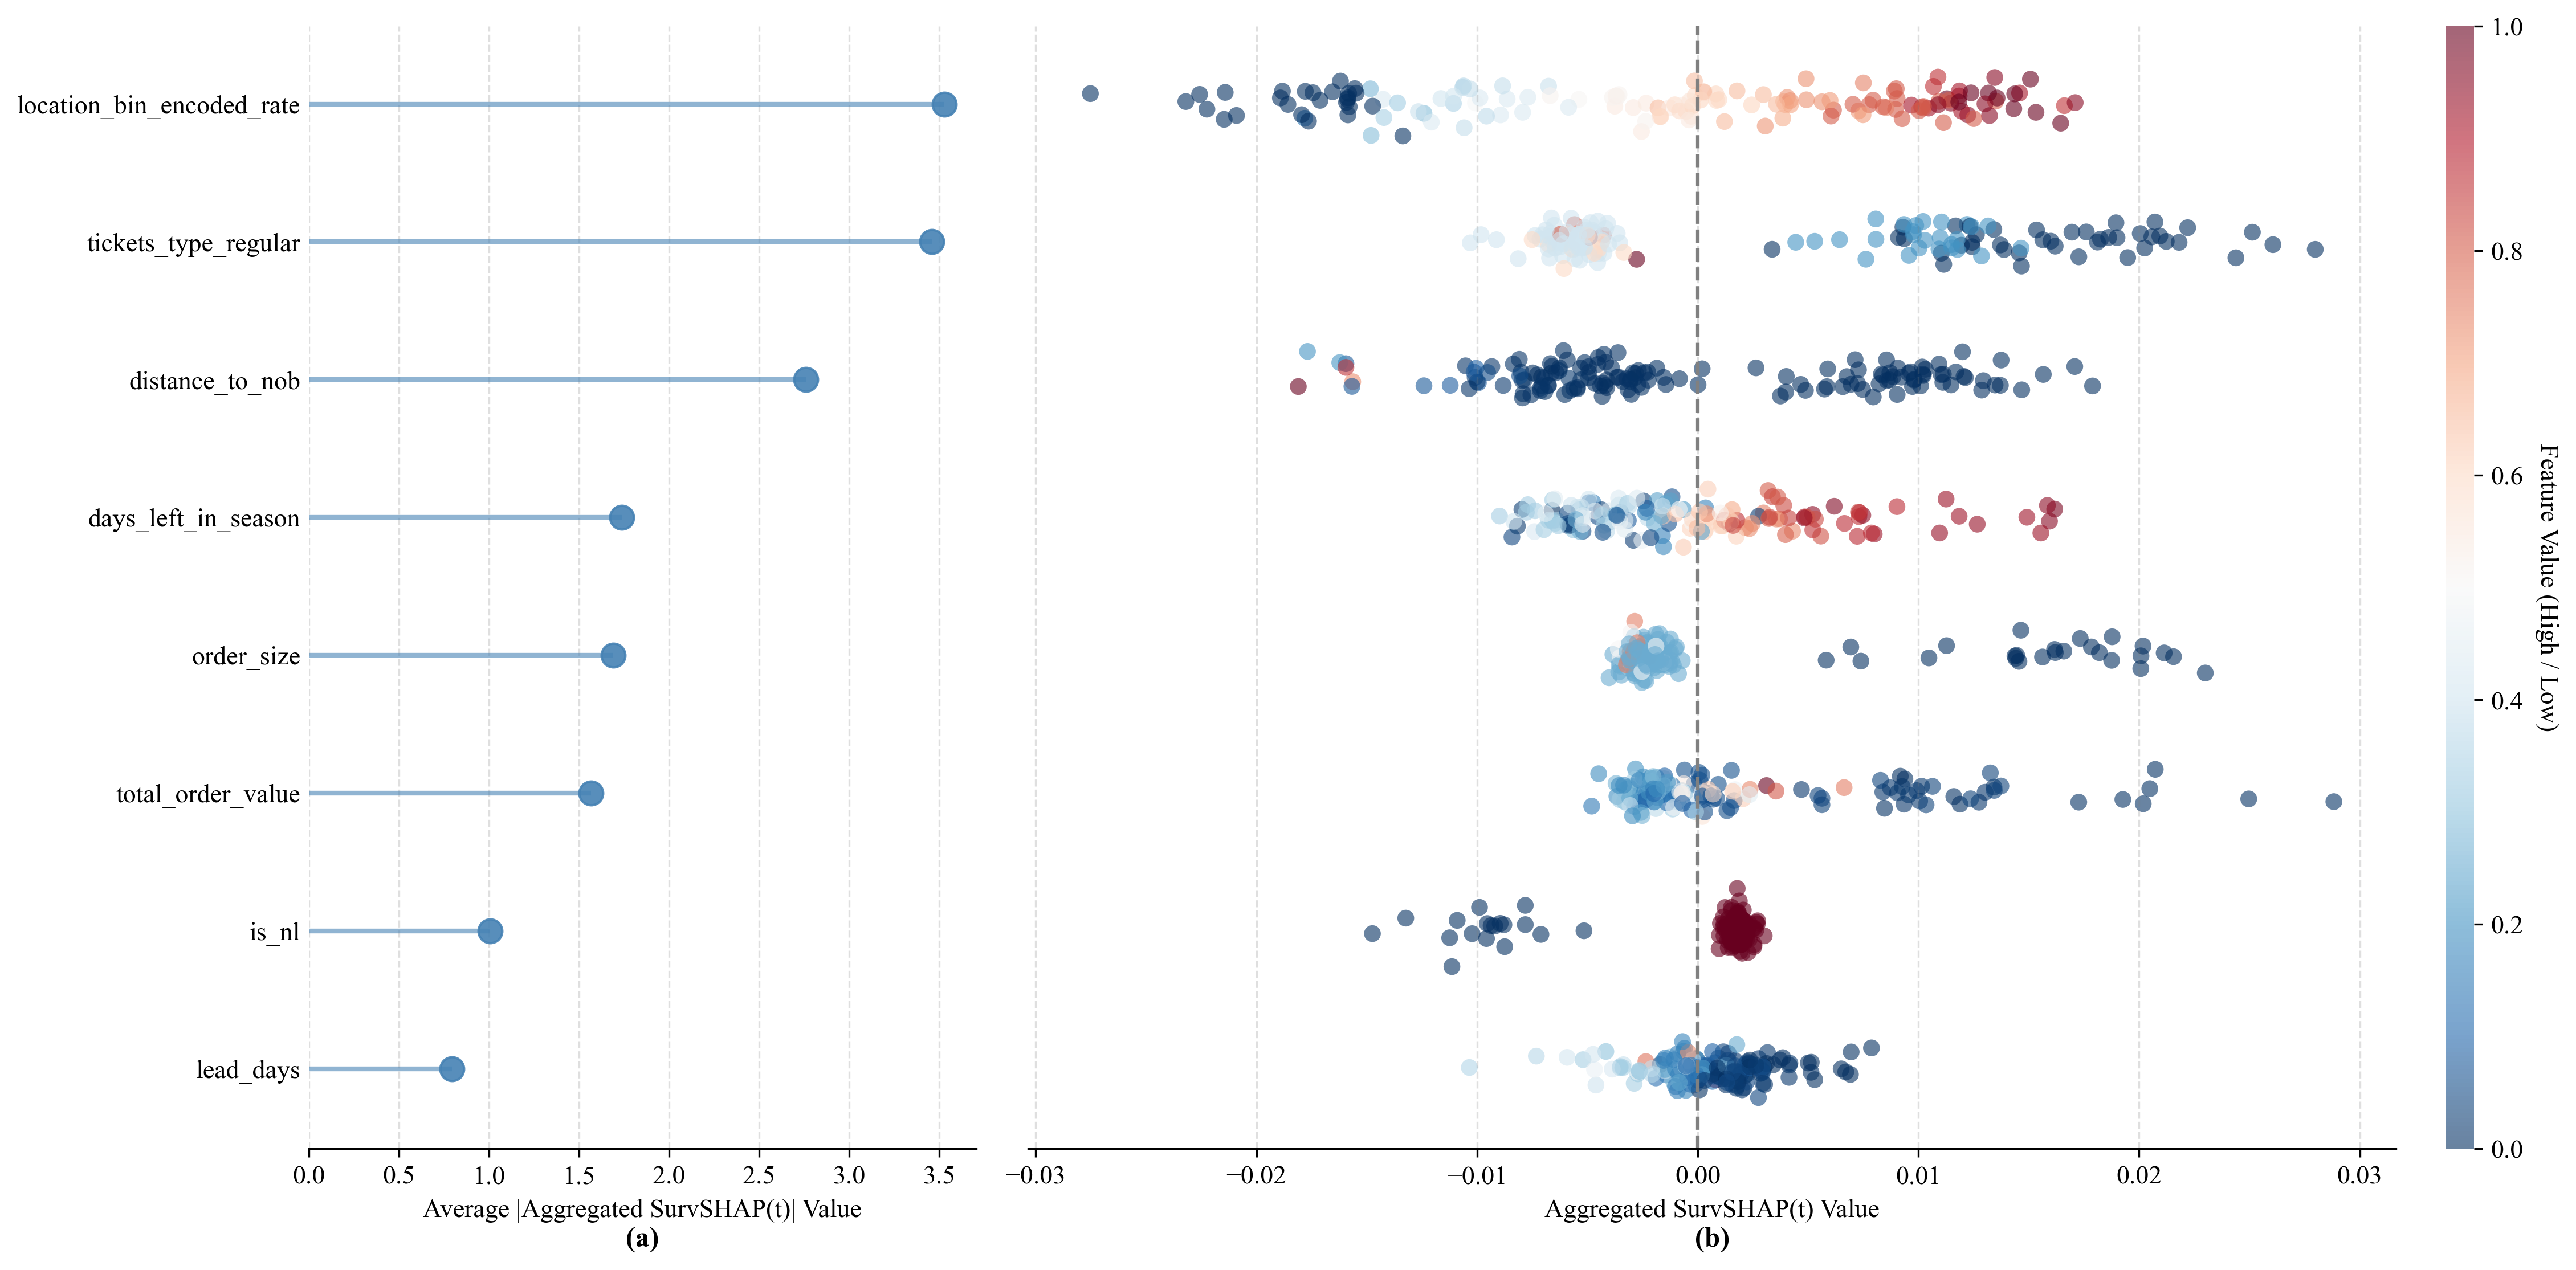

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_inverted_survshap_beeswarm(model_survshap, top_n=8):
    """
    Create a combined feature importance plot with a lollipop chart and a beeswarm plot.
    - Left (Lollipop): Shows overall feature importance.
    - Right (Beeswarm): Shows the impact of each feature on individual predictions,
      with SHAP values INVERTED for intuitive interpretation:
      - Positive SHAP = Encourages repurchase (good)
      - Negative SHAP = Discourages repurchase (bad)
    """
    # --- 1. Data Preparation (largely unchanged) ---
    # Get top features based on aggregated change
    importance_df = model_survshap.result[['variable_name', 'aggregated_change']].copy()
    importance_df.columns = ['feature', 'importance']
    importance_df = importance_df.sort_values('importance', ascending=False)
    top_features = importance_df.head(top_n)['feature'].tolist()
    
    # Extract SHAP values for each observation
    full_result_b0 = model_survshap.full_result[model_survshap.full_result['B'] == 0].copy()
    time_columns = [col for col in full_result_b0.columns if col.startswith('t = ')]
    
    plot_data = []
    for idx, row in full_result_b0.iterrows():
        if row['variable_name'] in top_features:
            # INVERT the SHAP values for intuitive meaning
            mean_shap = -row[time_columns].mean()
            plot_data.append({
                'feature': row['variable_name'],
                'aggregated_shap': mean_shap,
                'feature_value': row['variable_value']
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    # --- 2. Create Figure (MODIFIED) ---
    # MODIFICATION: Use sharey=True to align feature labels perfectly
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8),
                                   gridspec_kw={'width_ratios': [1, 2.5]},
                                   sharey=True)
    
    # Prepare data for plotting, sorted ascending for correct order in plot
    importance_sorted = importance_df.head(top_n).sort_values('importance', ascending=True)
    feature_order = importance_sorted['feature'].tolist()

    # --- 3. Left Plot: Lollipop Chart (REPLACED BAR CHART) ---
    # MODIFICATION: Replaced ax1.barh with hlines and scatter for a lollipop chart
    ax1.hlines(
        y=importance_sorted['feature'],
        xmin=0,
        xmax=importance_sorted['importance'],
        color='#4682B4',
        alpha=0.6,
        linewidth=2
    )
    ax1.scatter(
        x=importance_sorted['importance'],
        y=importance_sorted['feature'],
        s=100,
        color='#4682B4',
        alpha=0.9,
        zorder=3
    )
    
    # --- 4. Right Plot: Beeswarm (largely unchanged, but uses feature_order) ---
    # Normalize feature values for coloring (0 to 1)
    df_plot['feature_value_norm'] = 0.5
    for feature in top_features:
        mask = df_plot['feature'] == feature
        if mask.sum() > 0:
            vals = df_plot.loc[mask, 'feature_value'].values
            if vals.std() > 0:
                normalized = (vals - vals.min()) / (vals.max() - vals.min())
                df_plot.loc[mask, 'feature_value_norm'] = normalized
    
    # Plot with jitter
    np.random.seed(42)
    # MODIFICATION: Using feature_order ensures beeswarm aligns with lollipops
    for i, feature in enumerate(feature_order):
        feature_data = df_plot[df_plot['feature'] == feature]
        if len(feature_data) > 0:
            y_jitter = np.random.normal(0, 0.08, len(feature_data))
            y_positions = i + y_jitter
            
            # Keep a reference to the scatter plot for the colorbar
            scatter = ax2.scatter(
                feature_data['aggregated_shap'].values,
                y_positions,
                c=feature_data['feature_value_norm'].values,
                cmap='RdBu_r', vmin=0, vmax=1,
                s=50, alpha=0.6,
                edgecolors='none'
            )
            
    # --- 5. Styling and Customization (MODIFIED) ---
    # Add a main title for the whole figure

    # Style left plot (ax1)
    ax1.set_xlabel('Average |Aggregated SurvSHAP(t)| Value')
    ax1.set_title('(a)', loc='center', y=-0.1, weight='bold', fontsize=12)
    ax1.tick_params(axis='y', length=0) # Hide tick marks on y-axis
    ax1.spines[['top', 'right', 'left']].set_visible(False)
    ax1.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.25)
    ax1.set_xlim(0)

    # Style right plot (ax2)
    ax2.set_xlabel('Aggregated SurvSHAP(t) Value')
    ax2.set_title('(b)', loc='center', y=-0.1, weight='bold', fontsize=12)
    ax2.axvline(x=0, color='grey', linestyle='--', linewidth=1.5)
    ax2.spines[['top', 'right', 'left']].set_visible(False)
    ax2.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.25)
    
    # MODIFICATION: Because sharey=True, we only need to hide the tick marks
    ax2.tick_params(axis='y', length=0)
    
    # Create a single, clean colorbar
    # MODIFICATION: A more direct way to create the colorbar
    cbar = fig.colorbar(scatter, ax=ax2, aspect=40, pad=0.03)
    cbar.set_label('Feature Value (High / Low)', rotation=270, labelpad=15)
    cbar.outline.set_visible(False)
    
    # Final layout adjustment
    plt.tight_layout(rect=[0, 0, 1, 0.94]) # Adjust rect to make space for suptitle
    plt.show()
    
    return df_plot

# --- HOW TO RUN IT ---
# (Assuming you have your 'rsf_model_survshap' object ready)
df_inverted_plot_data = create_inverted_survshap_beeswarm(rsf_model_survshap, top_n=8)

In [302]:
y_train.shape, y_val.shape, y_test.shape

((59702, 2), (12549, 2), (12549, 2))

In [357]:
rsf_model_survshap.result

variable_name  variable_value    B  \
19             location_bin_encoded_rate        0.152662  0.0   
45                  tickets_type_regular        0.773702  0.0   
10                       distance_to_nob        0.286714  0.0   
7                    days_left_in_season        1.001829  0.0   
22                            order_size        0.517434  0.0   
51                     total_order_value        0.804198  0.0   
15                                 is_nl        0.880000  0.0   
18                             lead_days        0.785653  0.0   
20                         median_income        0.730701  0.0   
27                 prod_sales_cumulative        0.802643  0.0   
2                            age_over_55        0.146667  0.0   
43                 subscriber_percentage        0.021400  0.0   
31             sale_period_duration_days        0.840848  0.0   
30                    regular_percentage        0.887504  0.0   
21                        occupancy_rate        0.908904  0.0   
28                    purchase_month_cos        0.510286  0.0   
11                foreign_income_imputed        0.100000  0.0   
5                       daily_perf_sales        0.558230  0.0   
25                 perf_sales_cumulative        0.845056  0.0   
8                  days_since_sale_start        0.757166  0.0   
0                              age_18_35        0.366667  0.0   
26                 perf_sales_percentage        0.684617  0.0   
6                       daily_prod_sales        0.548346  0.0   
29                    purchase_month_sin        0.704449  0.0   
38                     start_month_march        0.153333  0.0   
4                 best_rank_per_purchase        0.795712  0.0   
1                              age_36_55        0.186667  0.0   
50                 tickets_type_youth_35        0.884790  0.0   
3                                artform        0.453333  0.0   
23          perf_free_tickets_cumulative        0.446669  0.0   
48                  tickets_type_student        0.493841  0.0   
42                 start_month_september        0.100000  0.0   
41                   start_month_october        0.140000  0.0   
9                       distance_imputed        0.066667  0.0   
32                     start_month_april        0.086667  0.0   
17                is_weekend_performance        0.486667  0.0   
12                         gender_female        0.580000  0.0   
33                  start_month_december        0.113333  0.0   
24  perf_operational_discount_cumulative        0.452929  0.0   
13                           gender_male        0.320000  0.0   
39                       start_month_may        0.033333  0.0   
40                  start_month_november        0.066667  0.0   
44         tickets_type_artform_discount        0.335895  0.0   
34                  start_month_february        0.120000  0.0   
37                      start_month_june        0.146667  0.0   
35                   start_month_january        0.033333  0.0   
16                           is_premiere        0.093333  0.0   
47                 tickets_type_stadspas        0.334650  0.0   
49                 tickets_type_youth_16        0.402038  0.0   
14                              is_flirt        0.026667  0.0   
46         tickets_type_special_discount        0.122933  0.0   
36                      start_month_july        0.006667  0.0   

    aggregated_change  index       t = 1.0       t = 2.0       t = 3.0  \
19           3.527643   74.5  6.040096e-04  8.769983e-04  1.074281e-03   
45           3.457284   74.5  3.356633e-04  2.831466e-04  4.348366e-04   
10           2.759227   74.5  4.908969e-04  6.555744e-04  6.123294e-04   
7            1.738404   74.5  8.486192e-04  1.211676e-03  1.360445e-03   
22           1.690884   74.5  4.411788e-04  5.003444e-04  6.383684e-04   
51           1.565797   74.5  1.882096e-04  2.721330e-04  2.868869e-04   
15           1.005296   74.5  3.401530e-04  4.077438e-04  4.847

In [363]:
# Calculate IPCW C-index for all models
cox_test_c_index_ipcw, cox_test_c_index_ipcw_se, cox_test_c_index_uno, cox_test_c_index_uno_se, cox_test_concordant = concordance_index_ipcw(
    y_train_struct,
    y_test_struct,
    cox_test_risks,
)

rsf_test_c_index_ipcw, rsf_test_c_index_ipcw_se, rsf_test_c_index_uno, rsf_test_c_index_uno_se, rsf_test_concordant = concordance_index_ipcw(
    y_train_struct,
    y_test_struct,
    rsf_test_risks,
)

xgbse_test_c_index_ipcw, xgbse_test_c_index_ipcw_se, xgbse_test_c_index_uno, xgbse_test_c_index_uno_se, xgbse_test_concordant = concordance_index_ipcw(
    y_train_struct,
    y_test_struct,
    xgbse_test_risks,
)

deephit_test_c_index_ipcw, deephit_test_c_index_ipcw_se, deephit_test_c_index_uno, deephit_test_c_index_uno_se, deephit_test_concordant = concordance_index_ipcw(
    y_train_struct,
    y_test_struct,
    deephit_test_risks,
)

deepsurv_test_c_index_ipcw, deepsurv_test_c_index_ipcw_se, deepsurv_test_c_index_uno, deepsurv_test_c_index_uno_se, deepsurv_test_concordant = concordance_index_ipcw(
    y_train_struct,
    y_test_struct,
    deepsurv_test_risks,
)

# Print all IPCW C-index results
print("=== IPCW C-index Results ===")
print(f"Cox test C-index (IPCW): {cox_test_c_index_ipcw:.5f} ± {cox_test_c_index_ipcw_se:.5f}")
print(f"RSF test C-index (IPCW): {rsf_test_c_index_ipcw:.5f} ± {rsf_test_c_index_ipcw_se:.5f}")
print(f"XGBSE test C-index (IPCW): {xgbse_test_c_index_ipcw:.5f} ± {xgbse_test_c_index_ipcw_se:.5f}")
print(f"DeepHit test C-index (IPCW): {deephit_test_c_index_ipcw:.5f} ± {deephit_test_c_index_ipcw_se:.5f}")
print(f"DeepSurv test C-index (IPCW): {deepsurv_test_c_index_ipcw:.5f} ± {deepsurv_test_c_index_ipcw_se:.5f}")

print("\n=== Uno's C-index Results ===")
print(f"Cox test C-index (Uno): {cox_test_c_index_uno:.5f} ± {cox_test_c_index_uno_se:.5f}")
print(f"RSF test C-index (Uno): {rsf_test_c_index_uno:.5f} ± {rsf_test_c_index_uno_se:.5f}")
print(f"XGBSE test C-index (Uno): {xgbse_test_c_index_uno:.5f} ± {xgbse_test_c_index_uno_se:.5f}")
print(f"DeepHit test C-index (Uno): {deephit_test_c_index_uno:.5f} ± {deephit_test_c_index_uno_se:.5f}")
print(f"DeepSurv test C-index (Uno): {deepsurv_test_c_index_uno:.5f} ± {deepsurv_test_c_index_uno_se:.5f}")

=== IPCW C-index Results ===
Cox test C-index (IPCW): 0.63036 ± 4608256.00000
RSF test C-index (IPCW): 0.66135 ± 4841843.00000
XGBSE test C-index (IPCW): 0.64550 ± 4722353.00000
DeepHit test C-index (IPCW): 0.64818 ± 4750530.00000
DeepSurv test C-index (IPCW): 0.65217 ± 4776683.00000

=== Uno's C-index Results ===
Cox test C-index (Uno): 2704467.00000 ± 21.00000
RSF test C-index (Uno): 2470856.00000 ± 45.00000
XGBSE test C-index (Uno): 2590265.00000 ± 126.00000
DeepHit test C-index (Uno): 2562190.00000 ± 24.00000
DeepSurv test C-index (Uno): 2536040.00000 ± 21.00000


In [ ]:
# Collect all best parameters for appendix
print("=== BEST HYPERPARAMETERS FOR ALL MODELS ===\n")

# Cox Model
print("1. COX PROPORTIONAL HAZARDS MODEL")
print("-" * 40)
with open('../../models/best_cox_params.json', 'r') as f:
    cox_params = json.load(f)
for param, value in cox_params.items():
    print(f"{param}: {value}")
print()

# Random Survival Forest
print("2. RANDOM SURVIVAL FOREST")
print("-" * 40)
with open('../../models/best_rsf_params.json', 'r') as f:
    rsf_params = json.load(f)
for param, value in rsf_params.items():
    print(f"{param}: {value}")
print()

# XGBSE
print("3. XGBSE (XGBoost Survival Embeddings)")
print("-" * 40)
with open('../../models/best_xgbse_params.json', 'r') as f:
    xgbse_params = json.load(f)
for param, value in xgbse_params.items():
    print(f"{param}: {value}")
print()

# DeepHit
print("4. DEEPHIT")
print("-" * 40)
with open('../../models/best_deephit_params.json', 'r') as f:
    deephit_params = json.load(f)
for param, value in deephit_params.items():
    print(f"{param}: {value}")
print()

# DeepSurv
print("5. DEEPSURV")
print("-" * 40)
with open('../../models/best_deepsurv_params.json', 'r') as f:
    deepsurv_params = json.load(f)
for param, value in deepsurv_params.items():
    print(f"{param}: {value}")

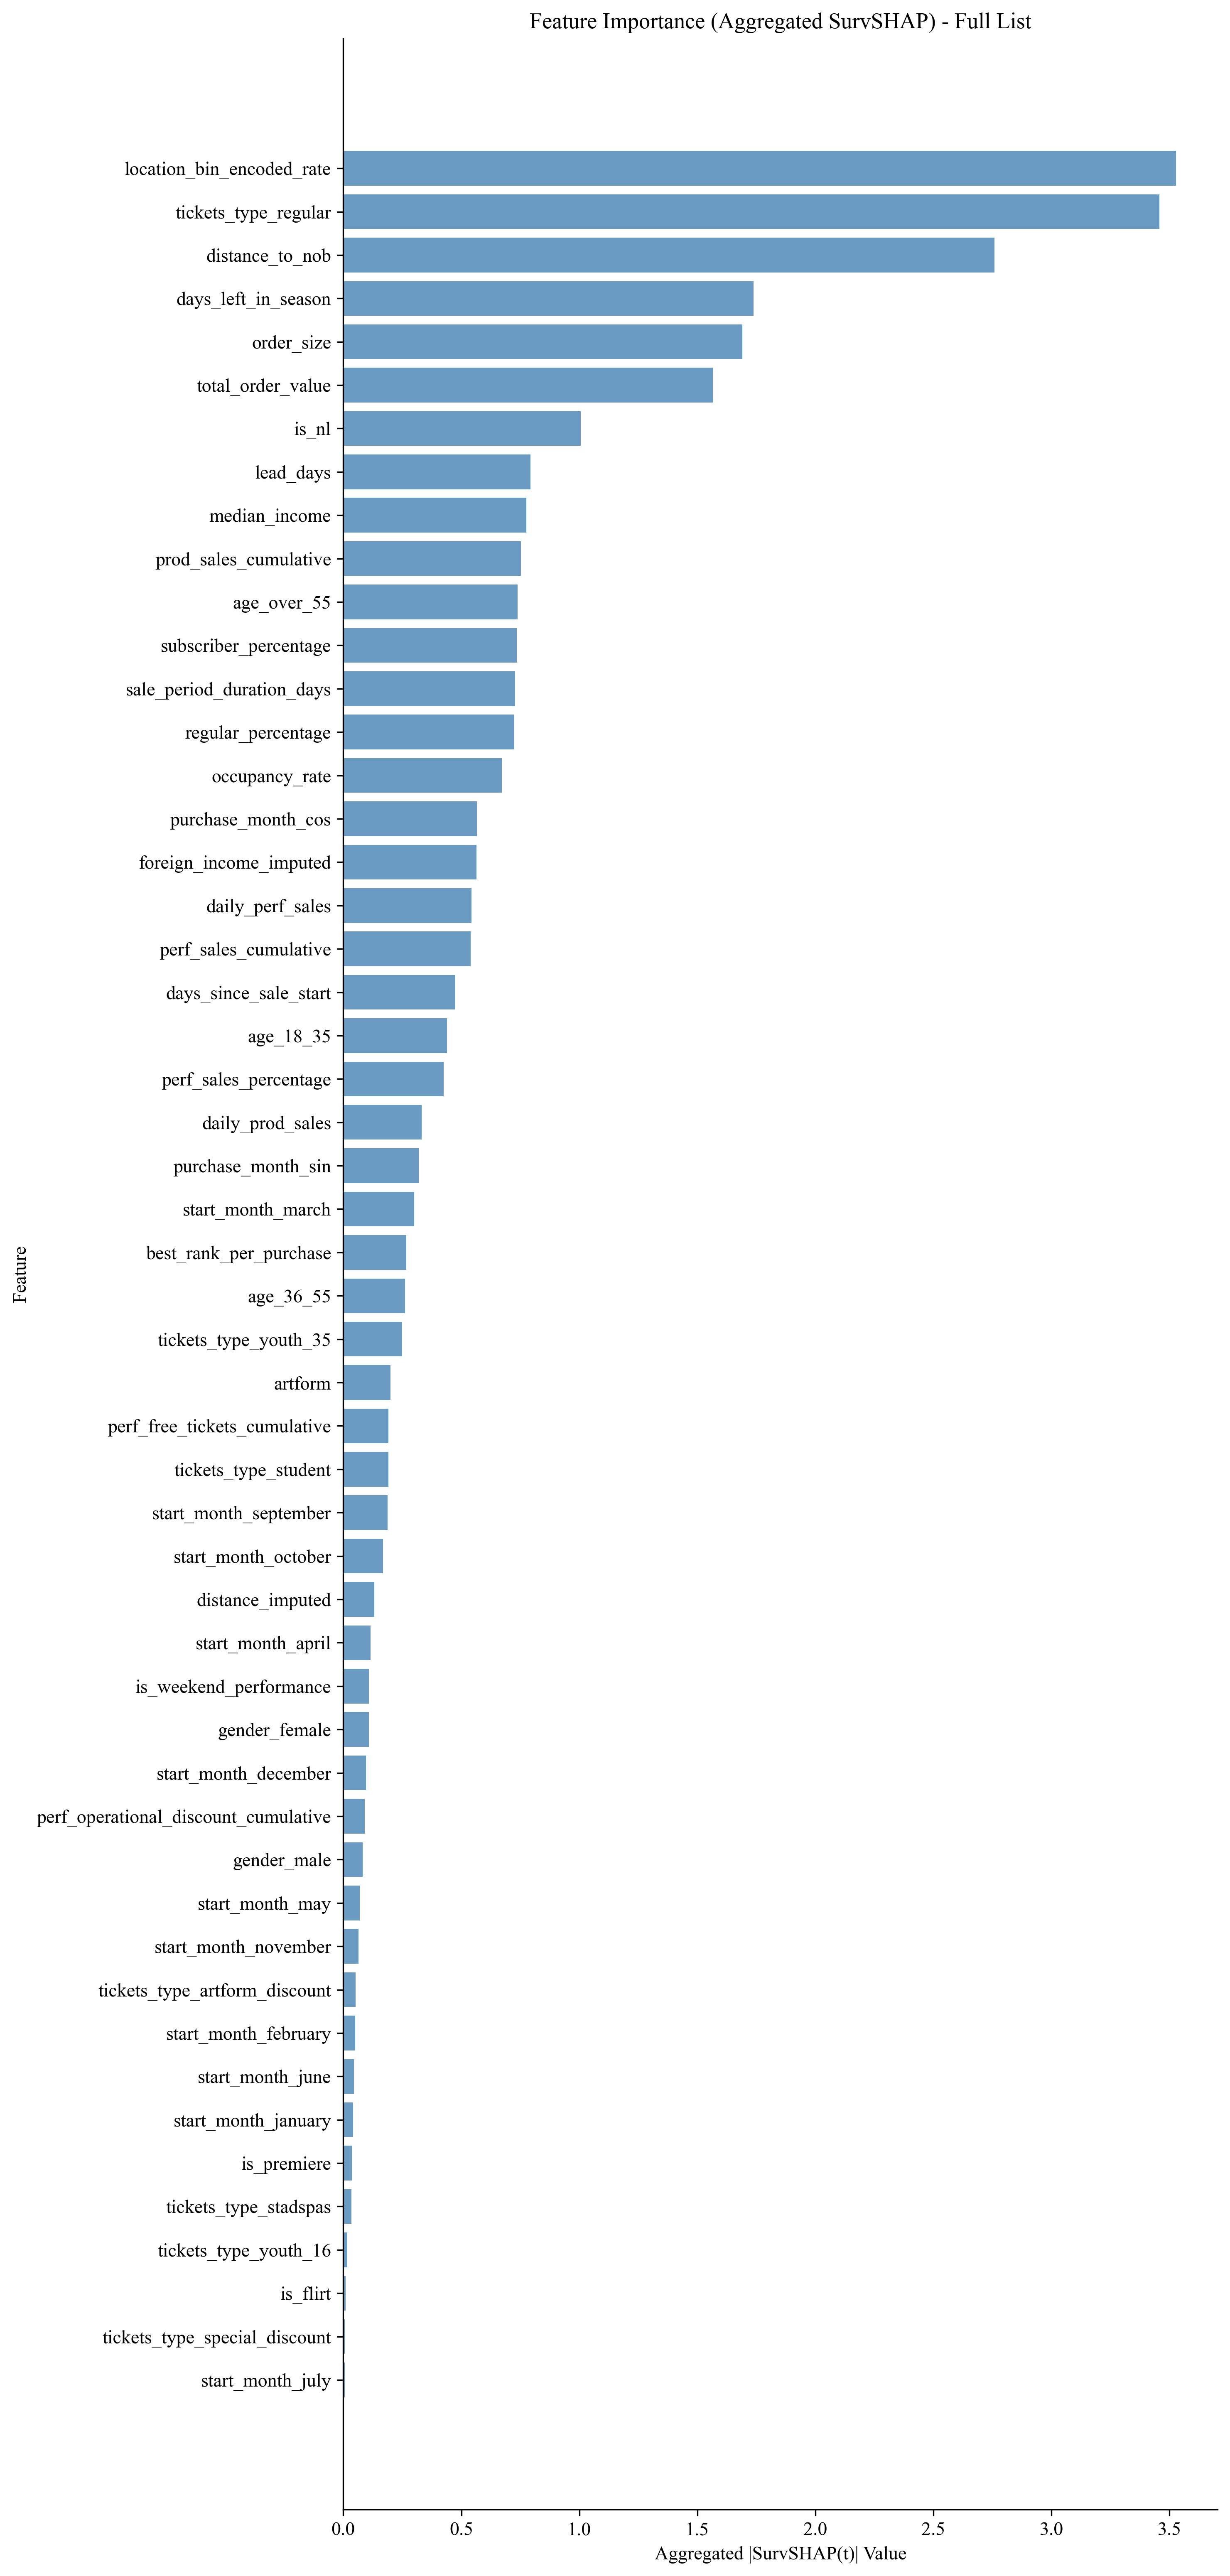

In [365]:
import matplotlib.pyplot as plt

# Get the full SurvSHAP results DataFrame
df = rsf_model_survshap.result

# Sort by aggregated_change (feature importance)
df_sorted = df.sort_values('aggregated_change', ascending=True)

plt.figure(figsize=(10, max(6, 0.4 * len(df_sorted))))
plt.barh(df_sorted['variable_name'], df_sorted['aggregated_change'], color='#4682B4', alpha=0.8)
plt.xlabel('Aggregated |SurvSHAP(t)| Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Aggregated SurvSHAP) - Full List')
plt.tight_layout()
plt.show()